In [55]:
import ast
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
tqdm.pandas()
plt.style.use('fivethirtyeight')
%matplotlib inline

from etl import CONFIG_PATH
from etl.utils import read_yaml, get_bins, read_table_from_database

In [298]:
def countplot(df: pd.DataFrame, feature: str):
    data = df[feature].fillna('None')
    fig, ax = plt.subplots(1, 1, figsize=(15, data.nunique()*1.2))
    sns.countplot(y=data, ax=ax, palette='deep')
    plt.show()

def hist_box_plot(df: pd.DataFrame, feature: str, kde: bool=False, label: str | None=None):
    
    print(f"Number of observations: {len(df)}")
    print(f"Number of None: {df[feature].isnull().sum()}")
    print(f"None ratio: {df[feature].isnull().sum()/len(df)}")
    if label == None:
        label = feature
    data = df[feature].dropna()
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    sns.histplot(data, bins=get_bins(len(data)), ax=ax[0], kde=kde)
    ax[0].set_xlabel(label)
    sns.boxplot(data, ax=ax[1])
    ax[1].set_ylabel(label)

def iqr_filter(df: pd.DataFrame, feature: str):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df2 = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    print(f'Initial number of observations: {len(df)}')
    print(f'Number of observations after IQR filtering along feature "{feature}": {len(df2)}')
    return df2

In [278]:
CONFIG = read_yaml(CONFIG_PATH)
df = read_table_from_database(
    table_name=CONFIG['transformation']['main_table_name'],
    is_source_db=False
)
FIELDS_CONFIG = CONFIG['transformation']['features']

[2024-07-16 15:48:50,192: 313: logger: INFO: utils: yaml file: /home/etl_project/src/etl/config.yaml loaded successfully]
[2024-07-16 15:48:50,281: 446: logger: INFO: utils: Table realty has been read from the destination database]


In [279]:
df = df.drop('date_parsed', axis=1).drop_duplicates()

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1352 entries, 0 to 4177
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   offer_id               1352 non-null   int64  
 1   address_id             1352 non-null   int64  
 2   n_rooms                1352 non-null   int64  
 3   is_studio              1352 non-null   bool   
 4   area                   1352 non-null   float64
 5   floor                  1351 non-null   float64
 6   total_floors           1346 non-null   float64
 7   height                 995 non-null    float64
 8   construction_year      1210 non-null   float64
 9   has_pledge             971 non-null    object 
 10  pledge                 811 non-null    float64
 11  commission_fee         1352 non-null   int64  
 12  utilities              1352 non-null   object 
 13  price                  1352 non-null   int64  
 14  latitude               1352 non-null   float64
 15  longitude

## Categorical features

In [280]:
cat_feats = [
    'n_rooms',
    'utilities',
    'is_studio',
    'has_pledge',
    'has_furniture',
    'has_kitchen_furniture',
    'building_type',
    'finishing_type',
    'balcony_cnt',
    'loggia_cnt',
    'window_view_type',
    'bathroom_type',
    'parking_type',
    'is_closed_area',
    'is_pet_available',
    'is_kid_available',
    'has_lift',
    'has_internet',
    'has_air_conditioner',
    'heating_type',
    'has_garbage_chute',
    'has_security',
    'has_dishwasher',
    'has_alarm',
    'has_washing_machine',
    'has_tv',
    'has_fridge',
    'has_phone',
    'is_individual_project'
]

[2024-07-16 15:48:53,813: 223: matplotlib.category: INFO: category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.]
[2024-07-16 15:48:53,822: 223: matplotlib.category: INFO: category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.]


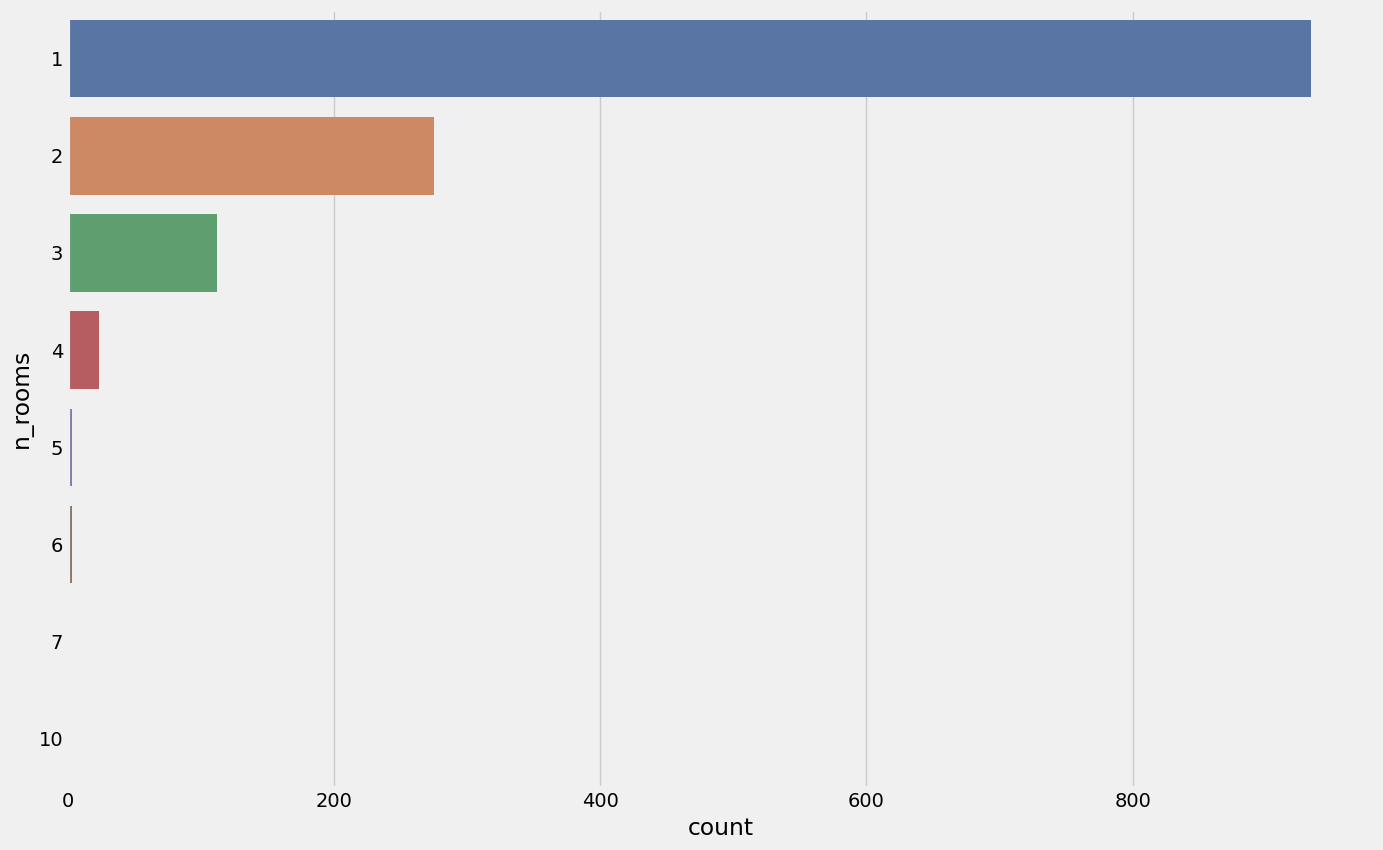

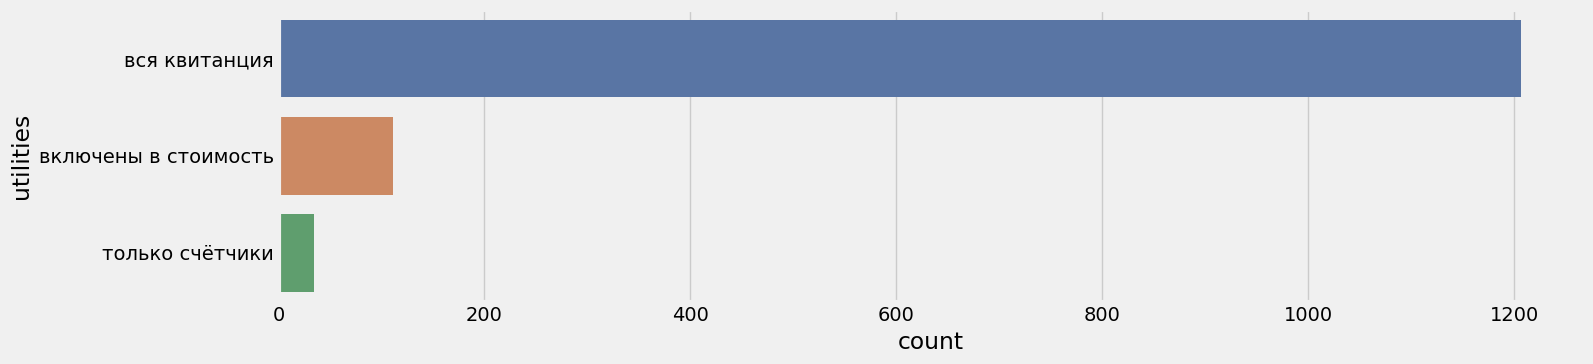

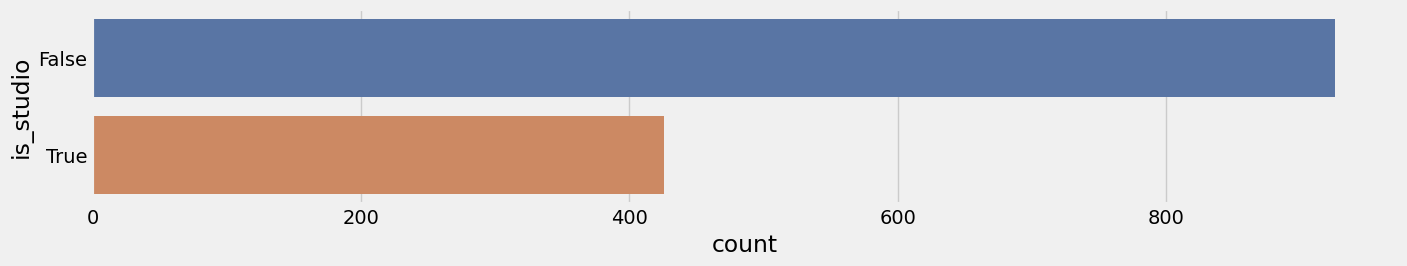

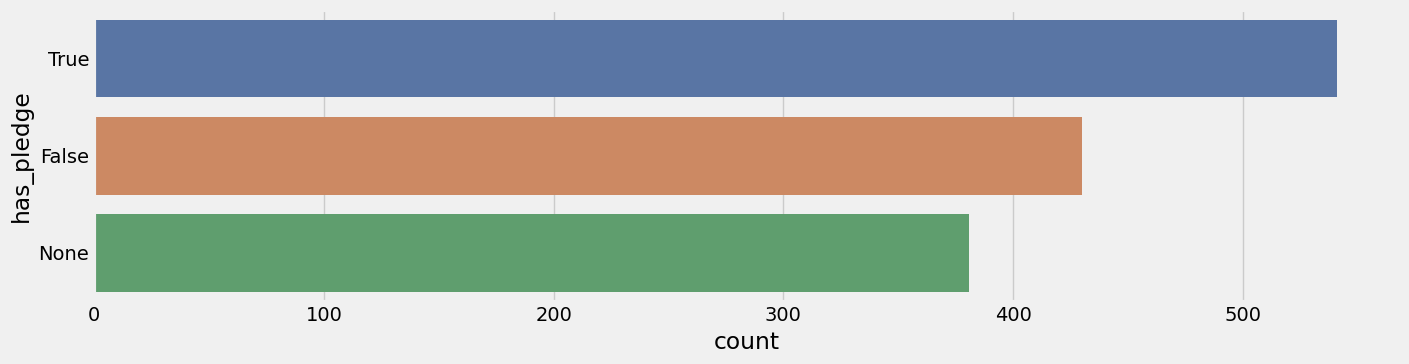

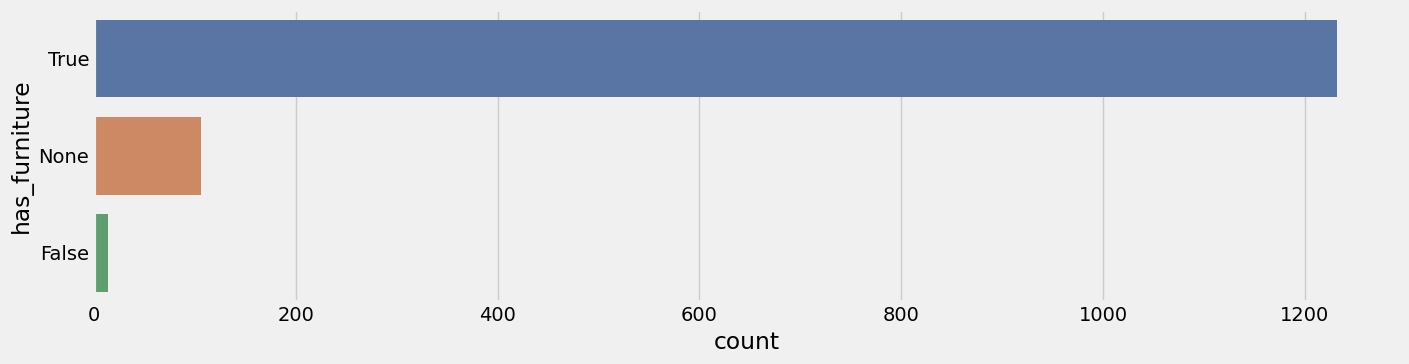

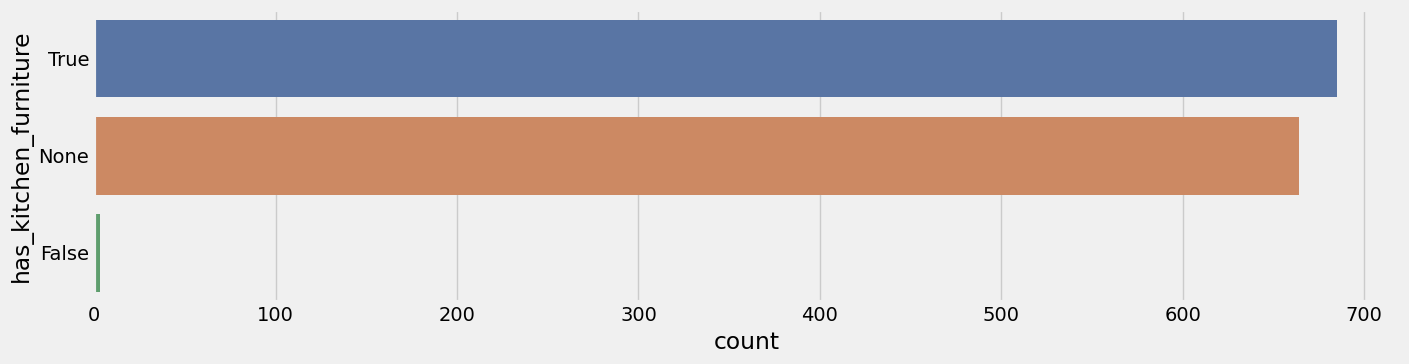

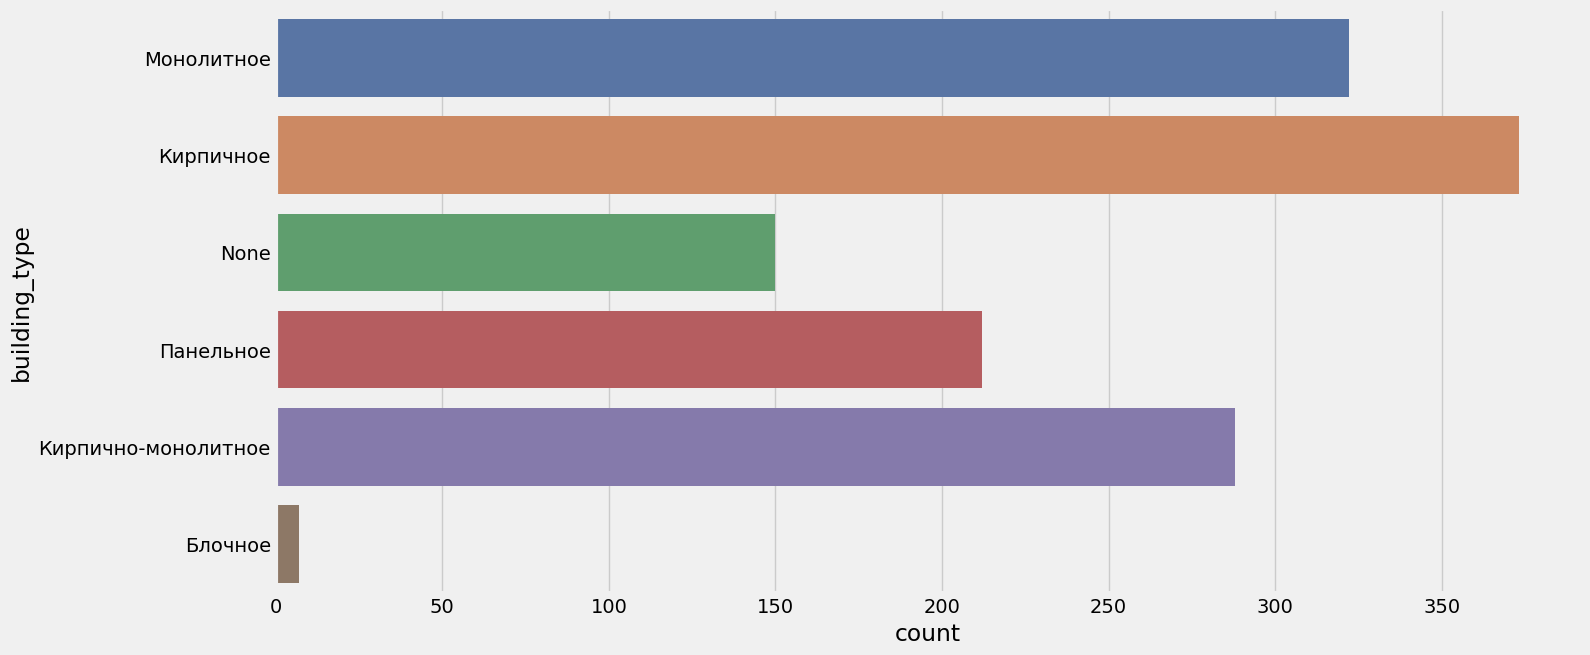

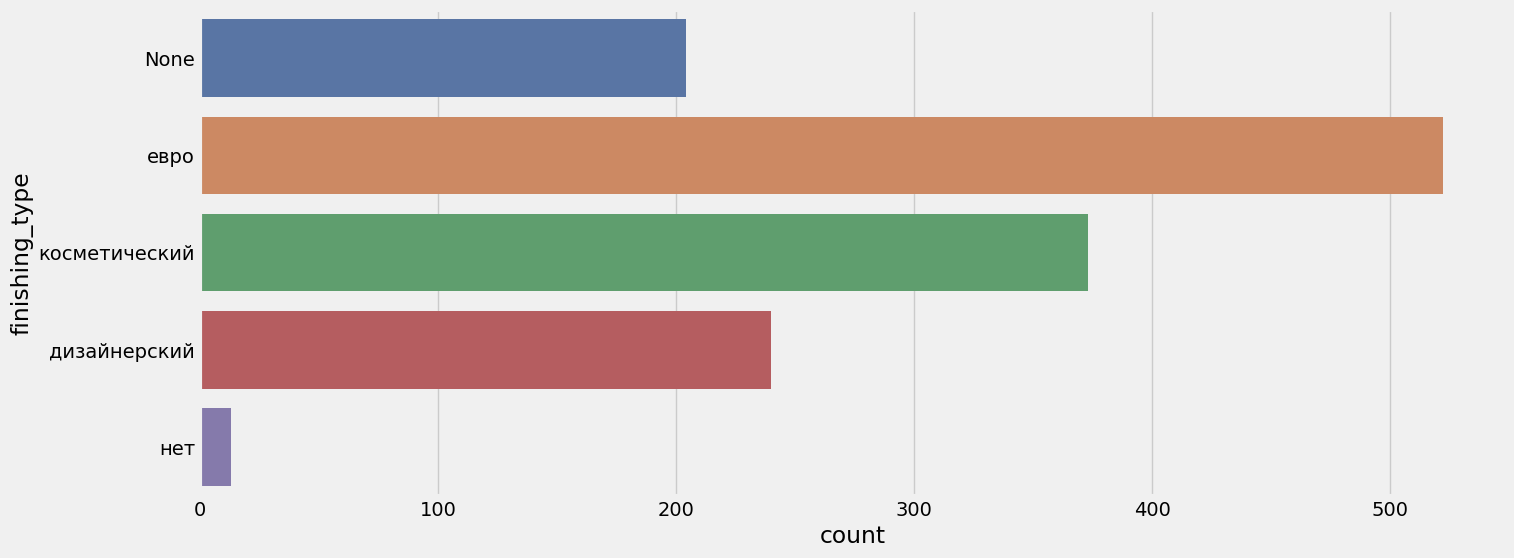

[2024-07-16 15:48:55,055: 223: matplotlib.category: INFO: category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.]
[2024-07-16 15:48:55,064: 223: matplotlib.category: INFO: category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.]


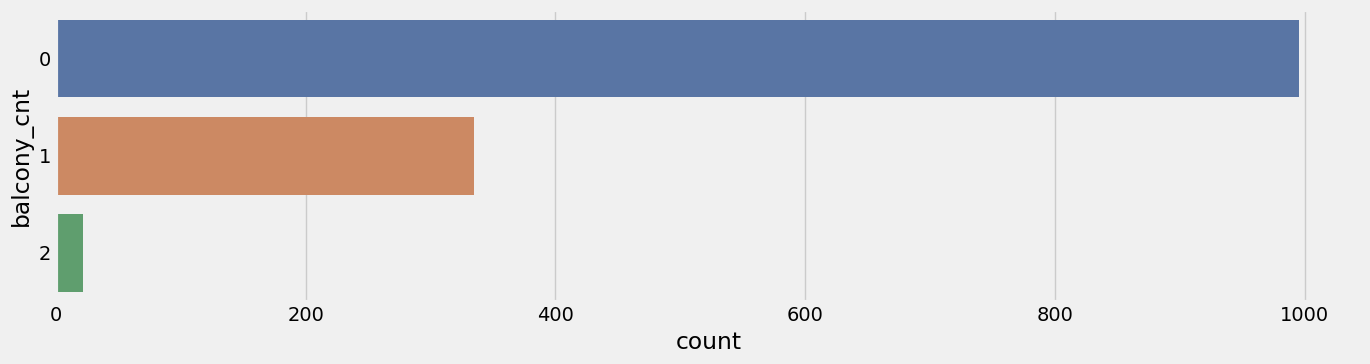

[2024-07-16 15:48:55,177: 223: matplotlib.category: INFO: category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.]
[2024-07-16 15:48:55,185: 223: matplotlib.category: INFO: category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.]


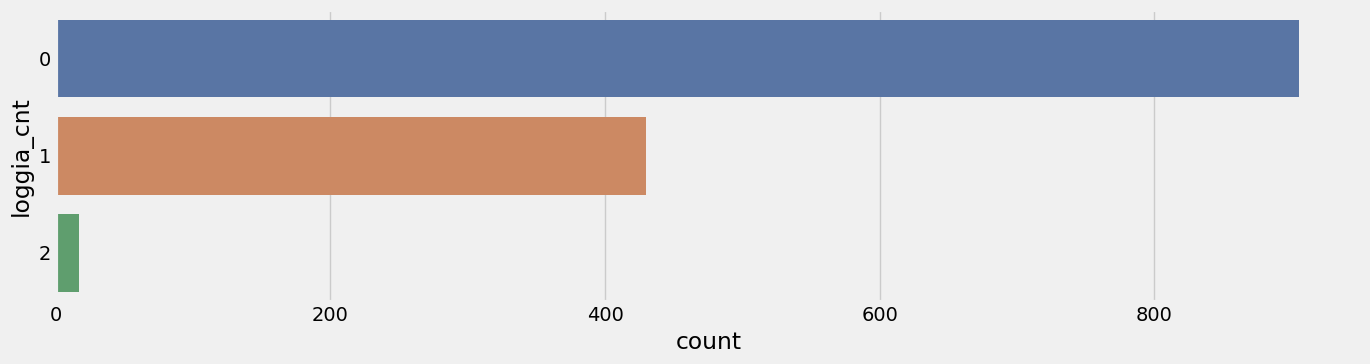

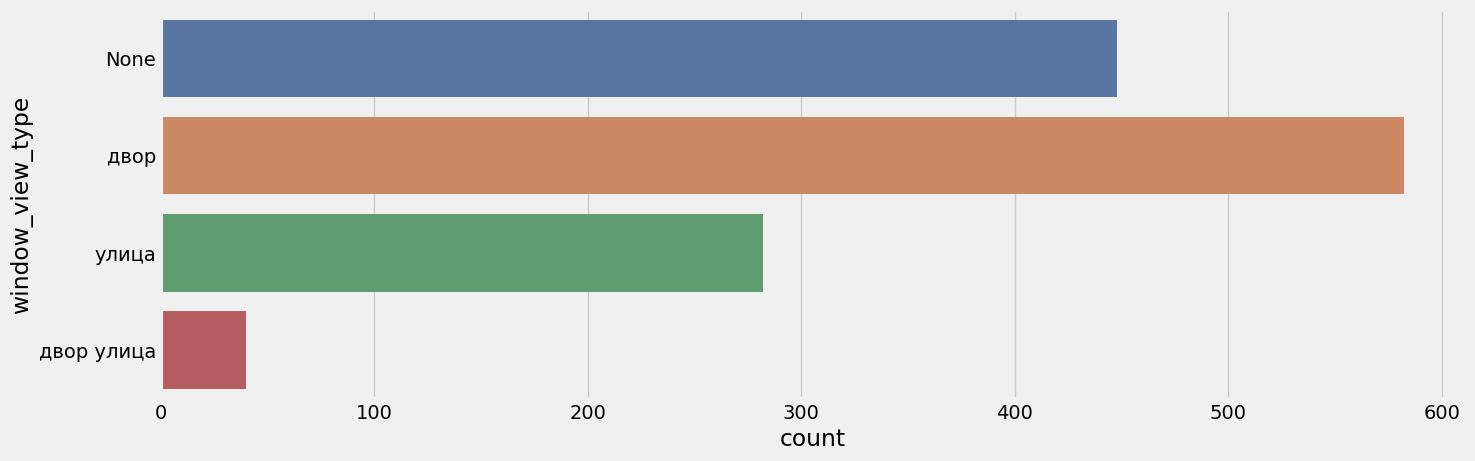

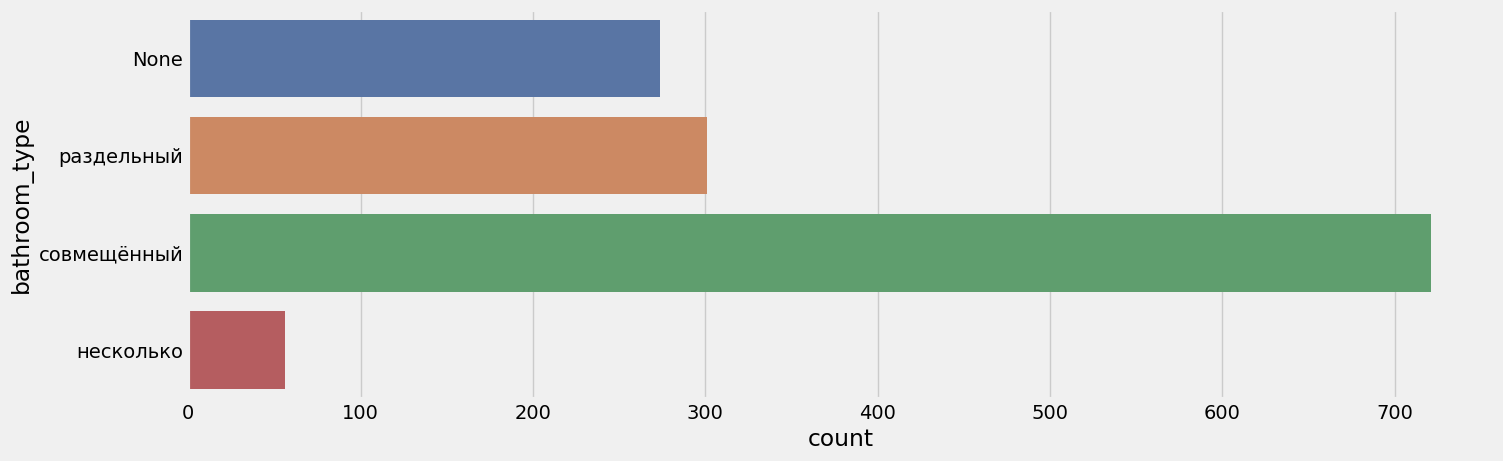

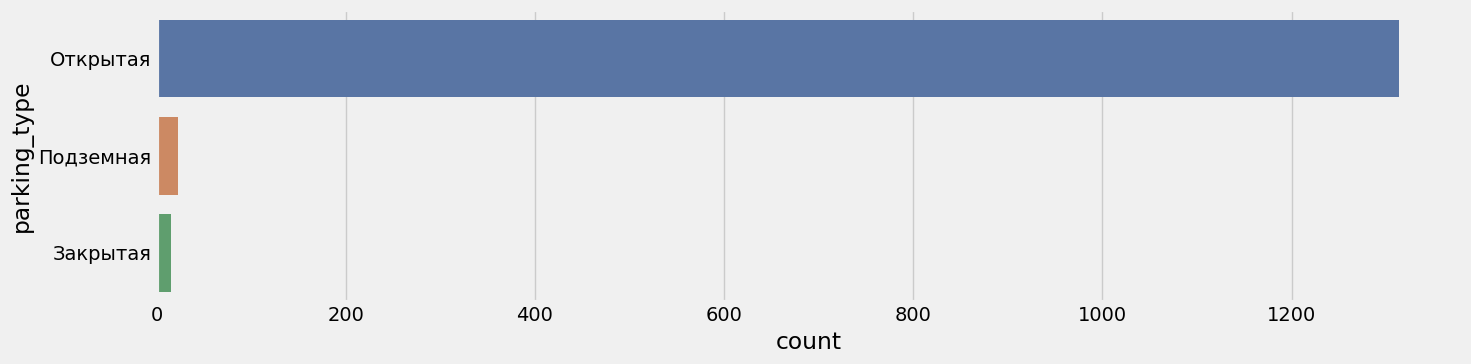

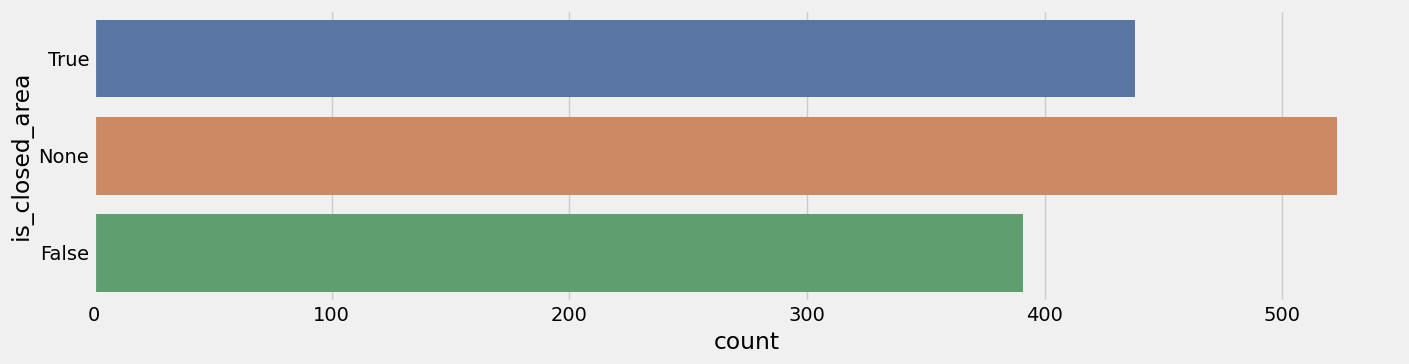

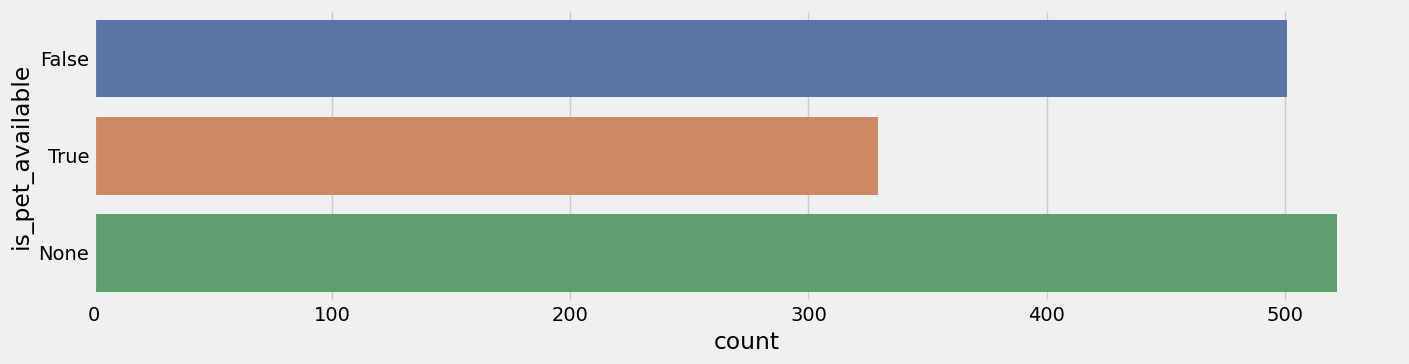

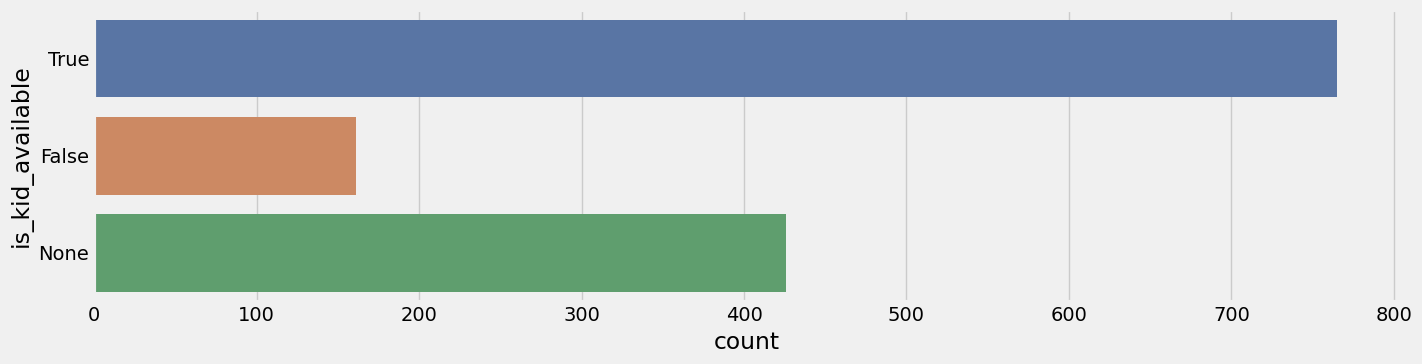

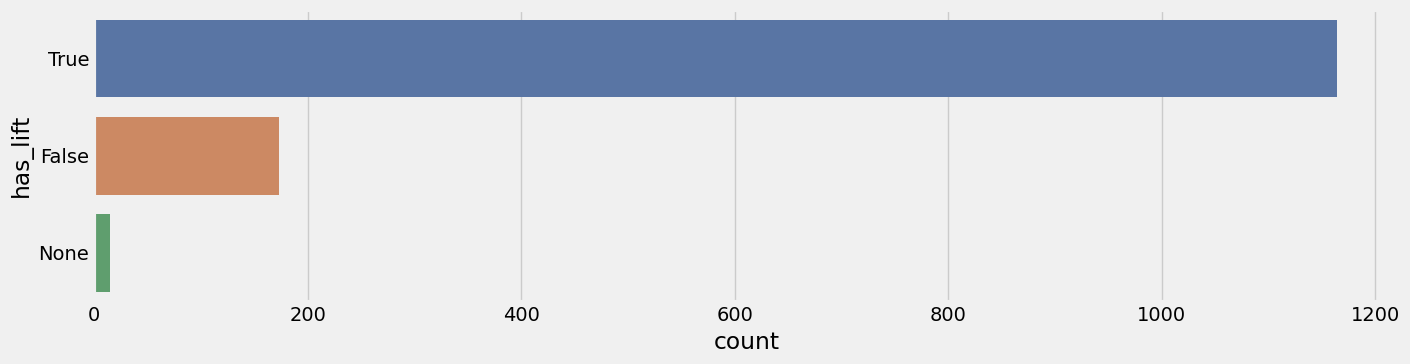

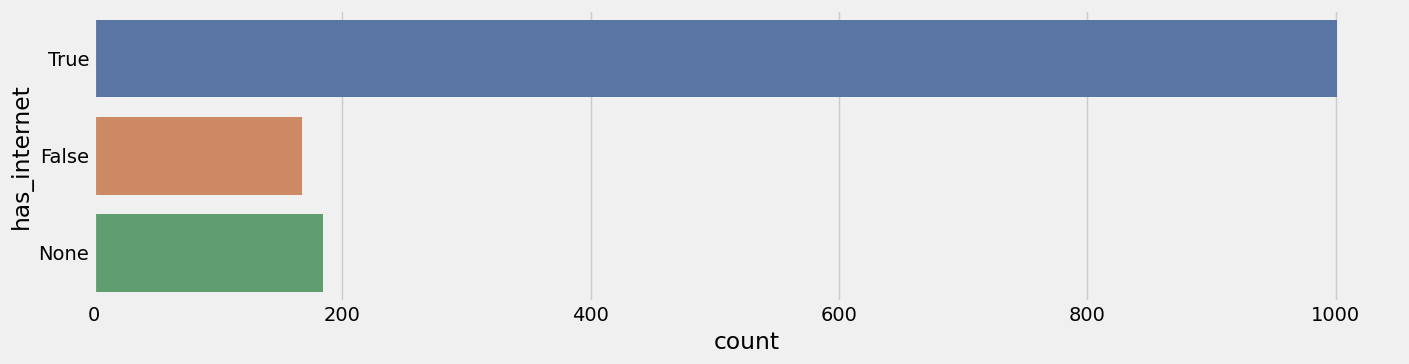

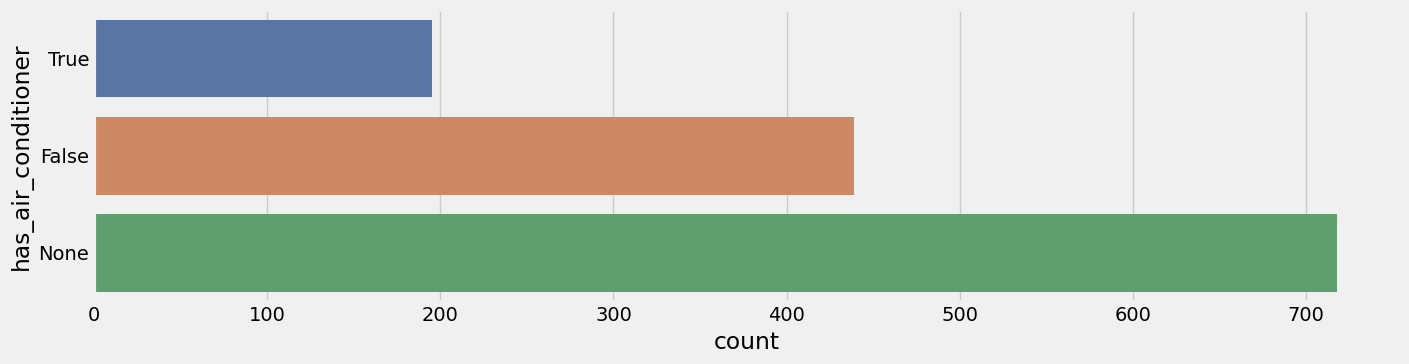

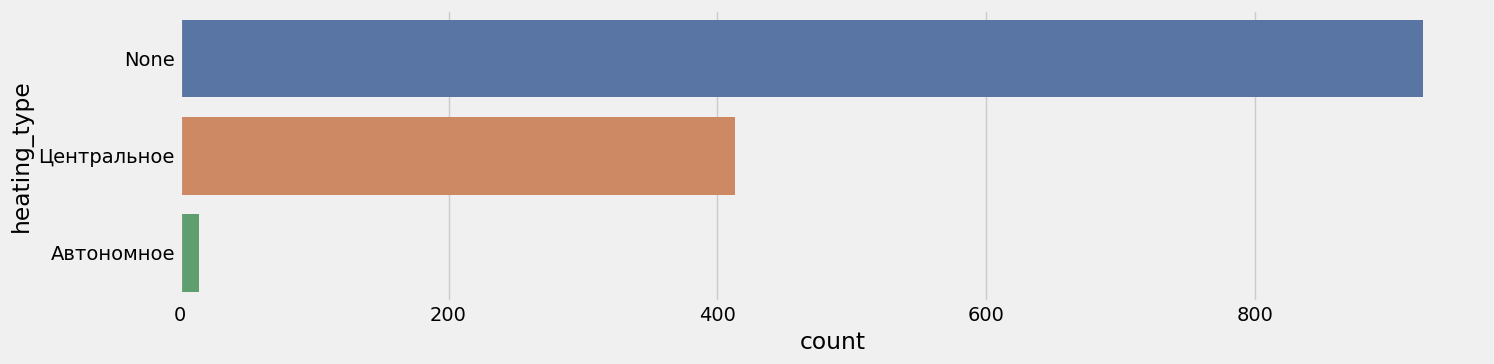

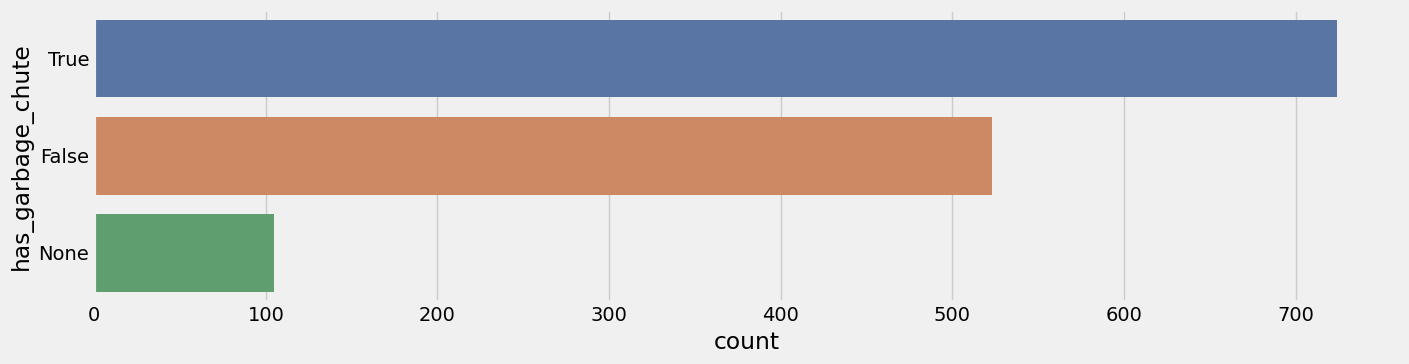

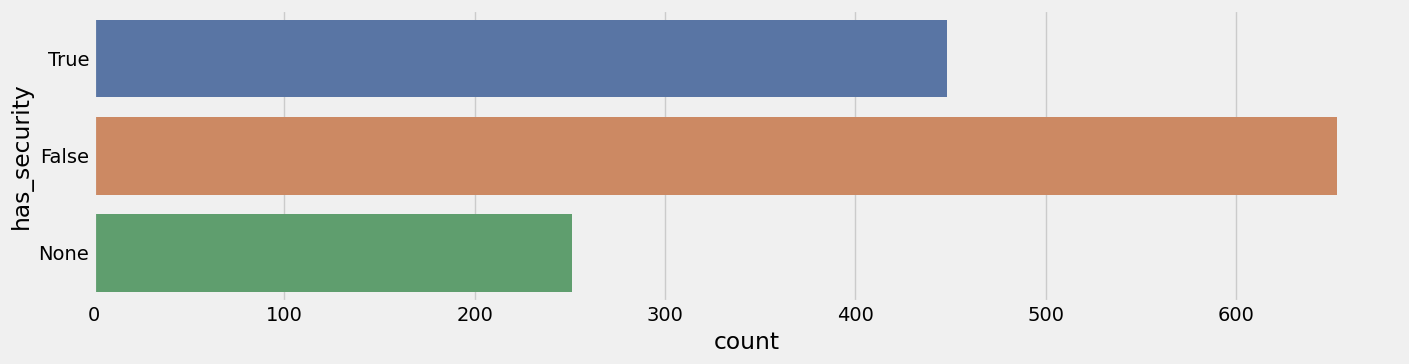

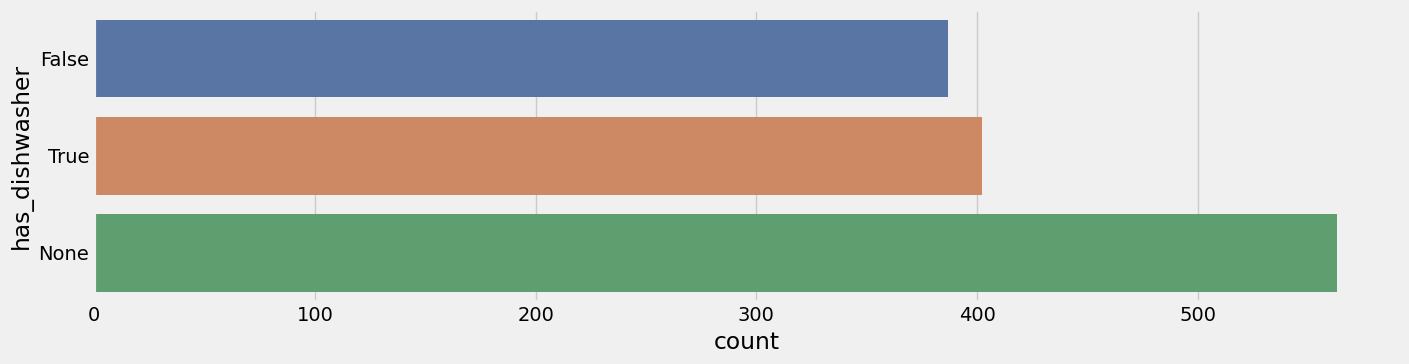

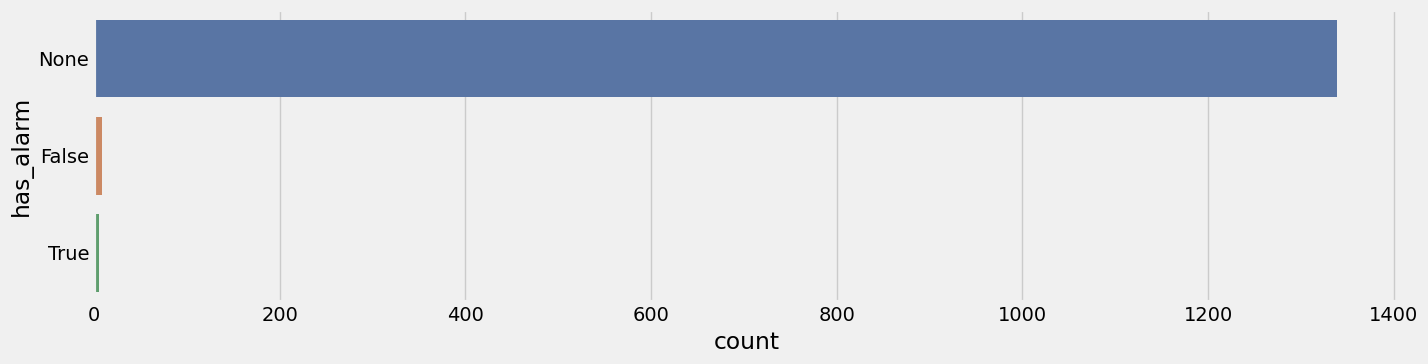

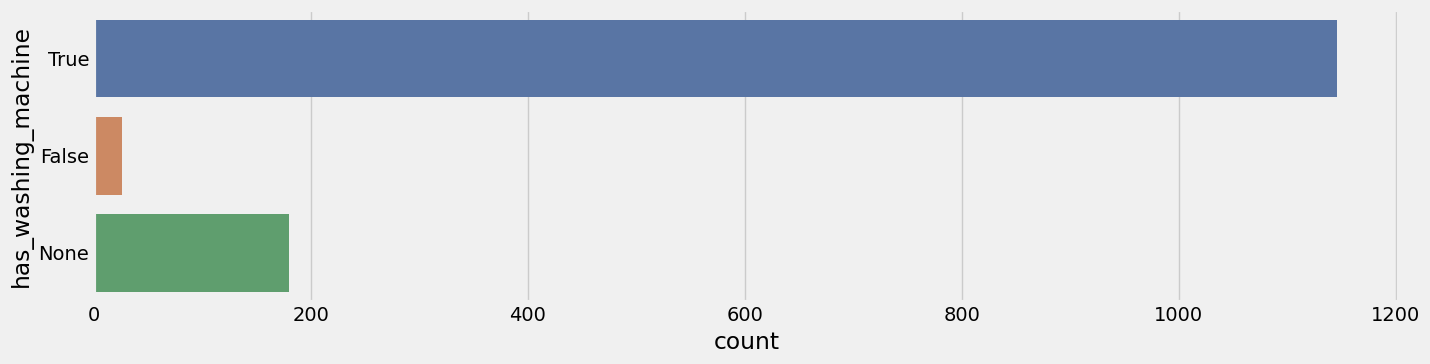

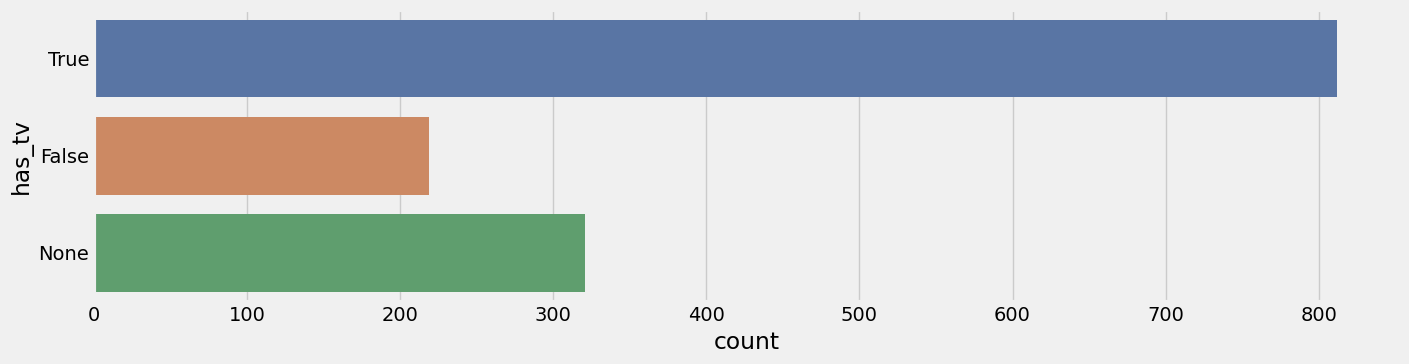

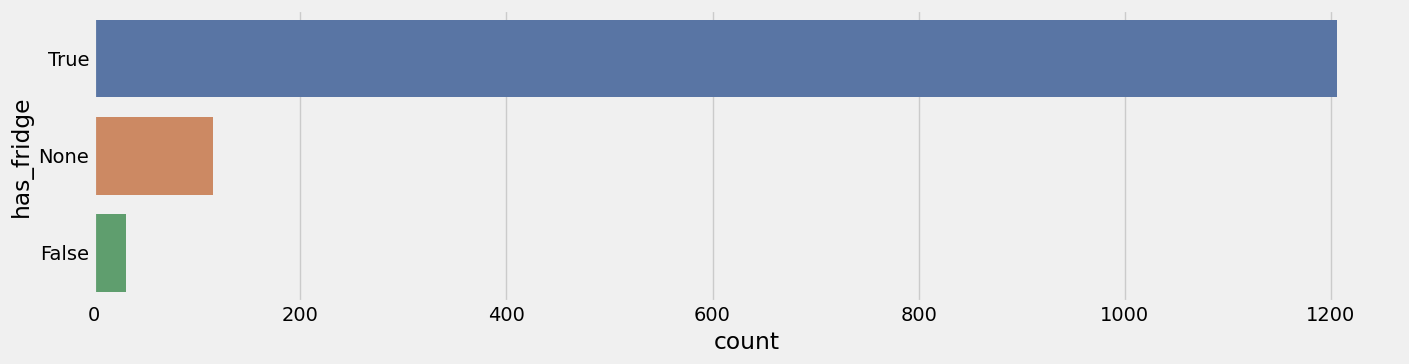

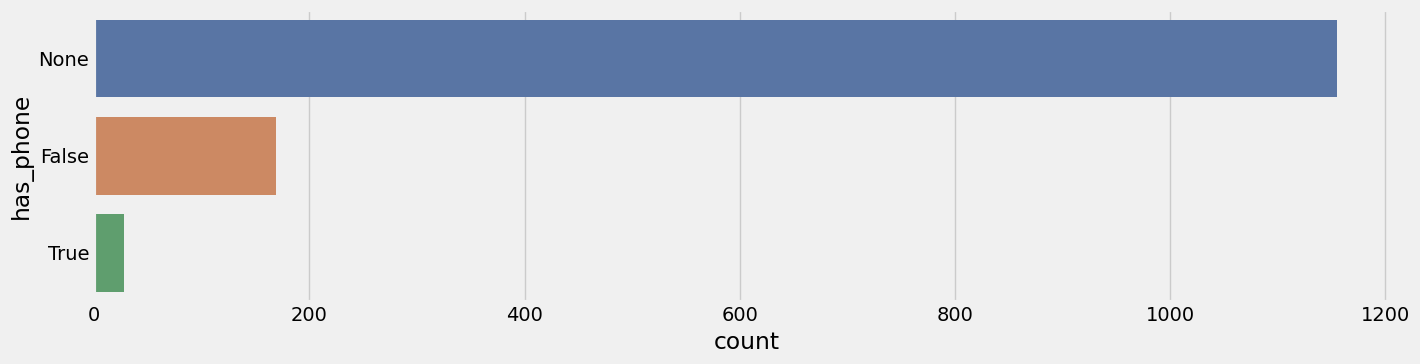

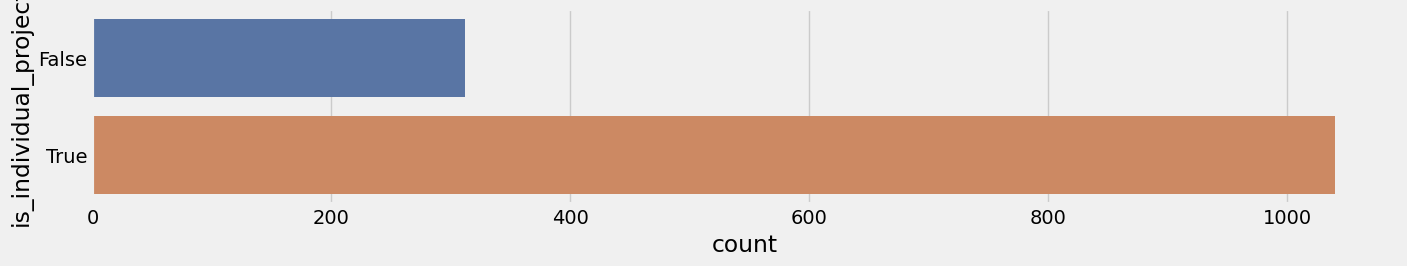

In [281]:
for feat in cat_feats:
    countplot(df, feat)

## Numerical features

### Height

Number of observations: 1352
Number of None: 357
None ratio: 0.2640532544378698


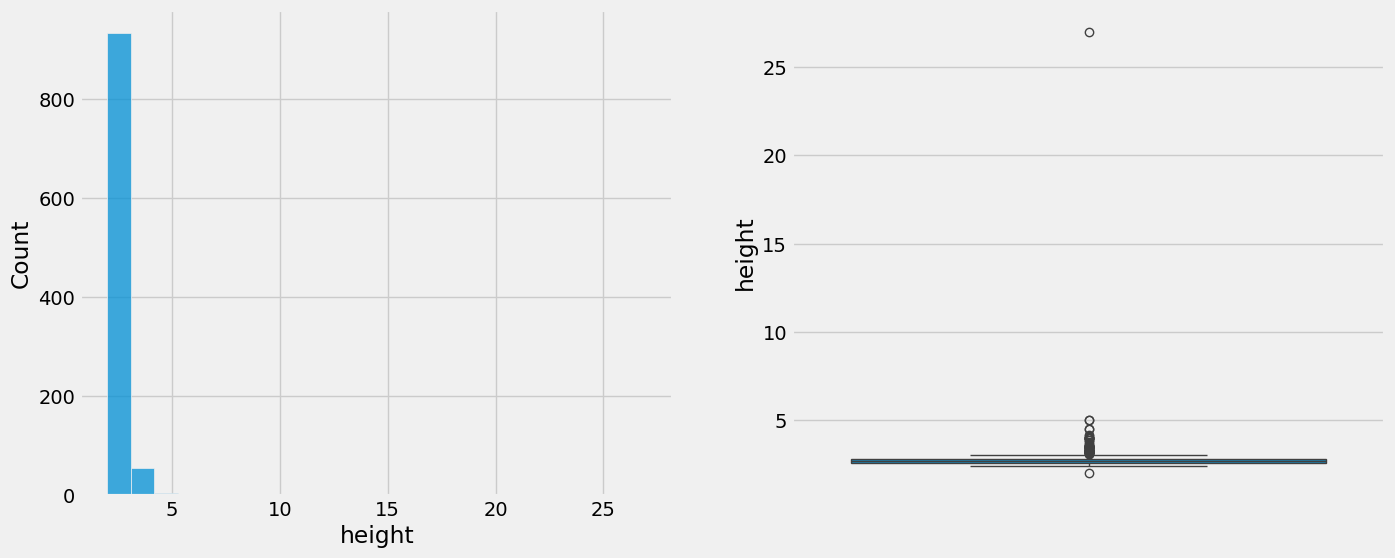

In [215]:
hist_box_plot(df, 'height')

In [216]:
print(f"Outlier: {df['height'].max().item()}")

Outlier: 27.0


It is clear that there is a strong outlier with the ceiling height = 27
Probably it was a missprint by owner : 27 -> 2.7

In [217]:
df['height'] = df['height'].replace(27, 2.7)

Number of observations: 1352
Number of None: 357
None ratio: 0.2640532544378698


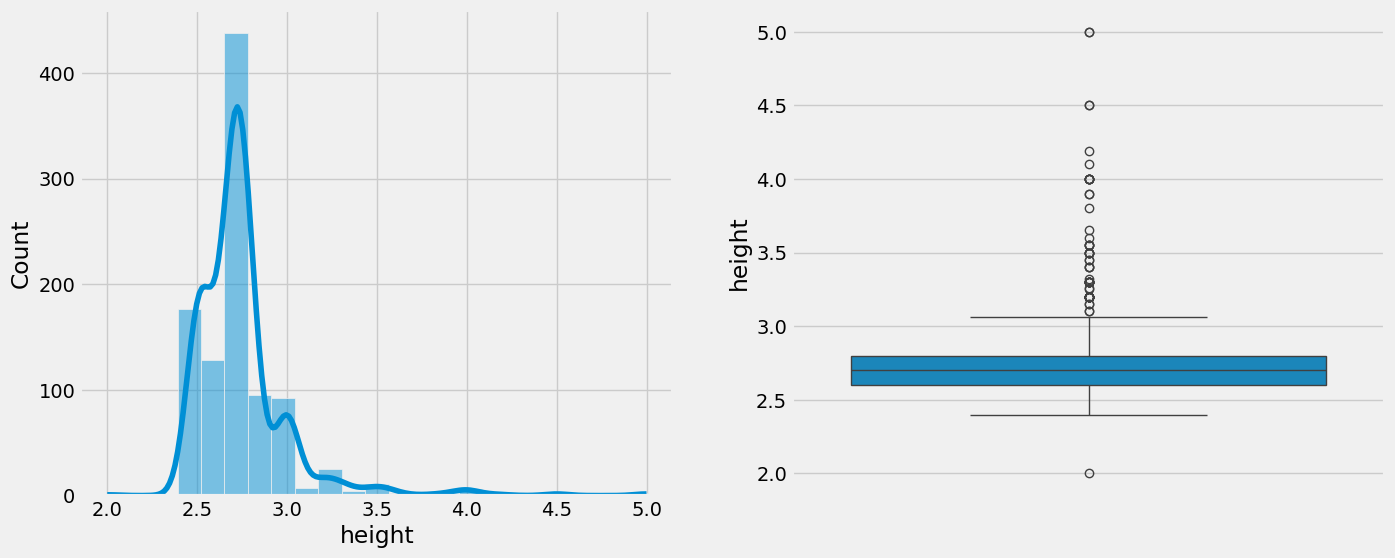

In [218]:
hist_box_plot(df, 'height', kde=True)

Number of observations: 933
Number of None: 0
None ratio: 0.0


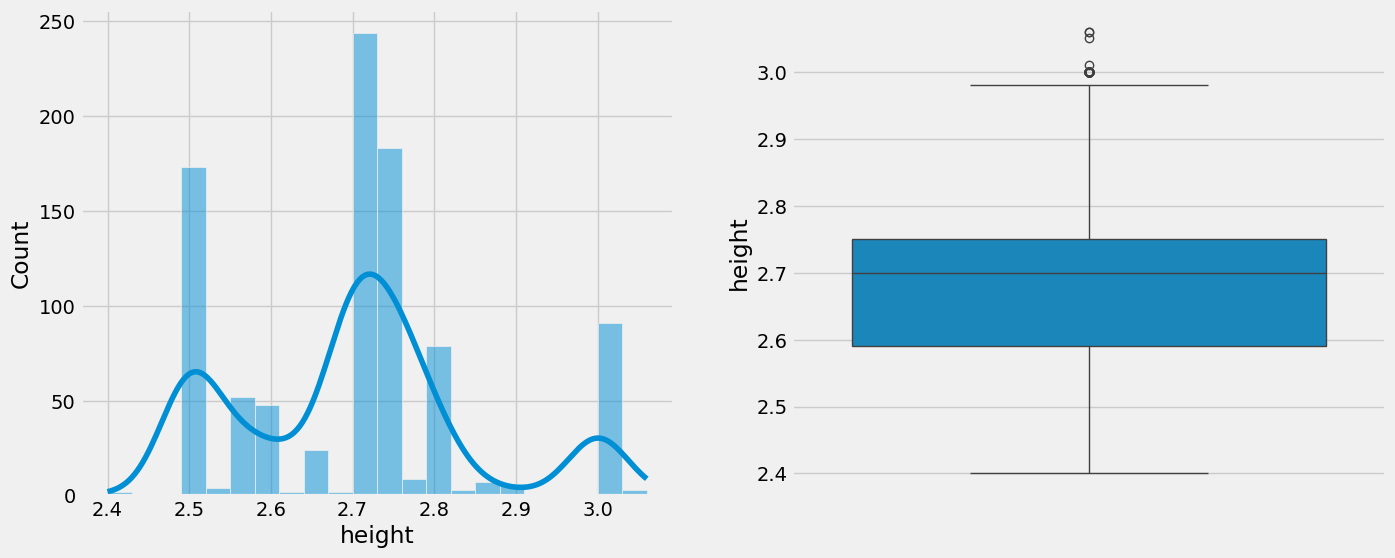

In [219]:
hist_box_plot(iqr_filter(df, 'height'), 'height', kde=True)

Number of observations: 839
Number of None: 0
None ratio: 0.0


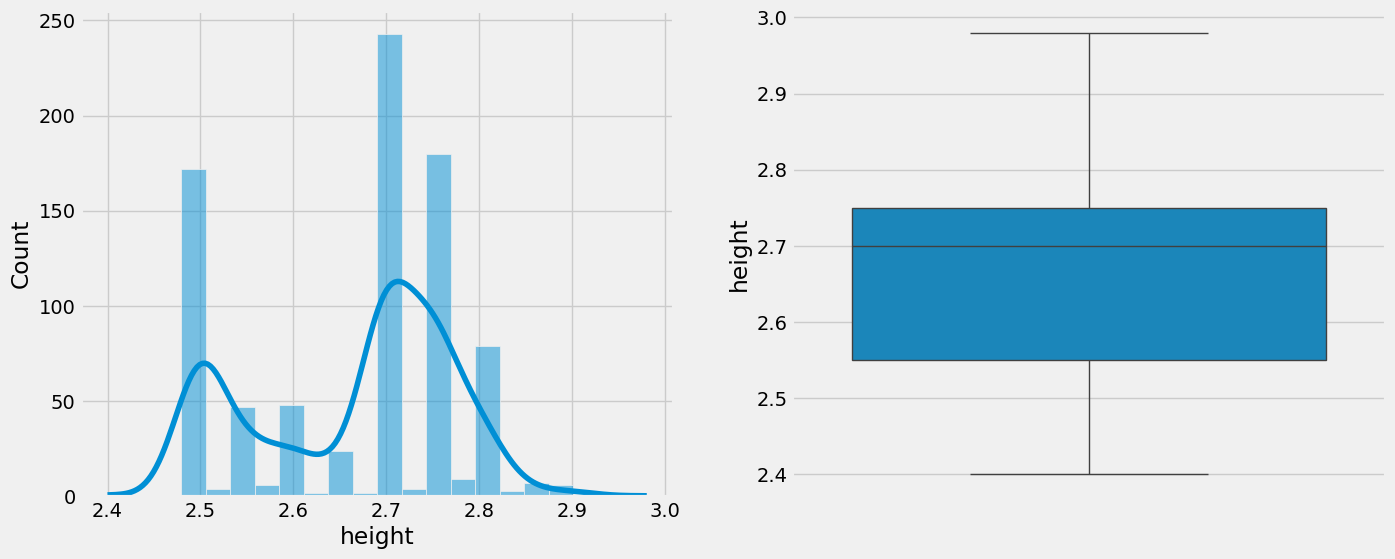

In [220]:
hist_box_plot(iqr_filter(iqr_filter(df, 'height'), 'height'), 'height', kde=True)

### construction_year

Number of observations: 1352
Number of None: 142
None ratio: 0.10502958579881656


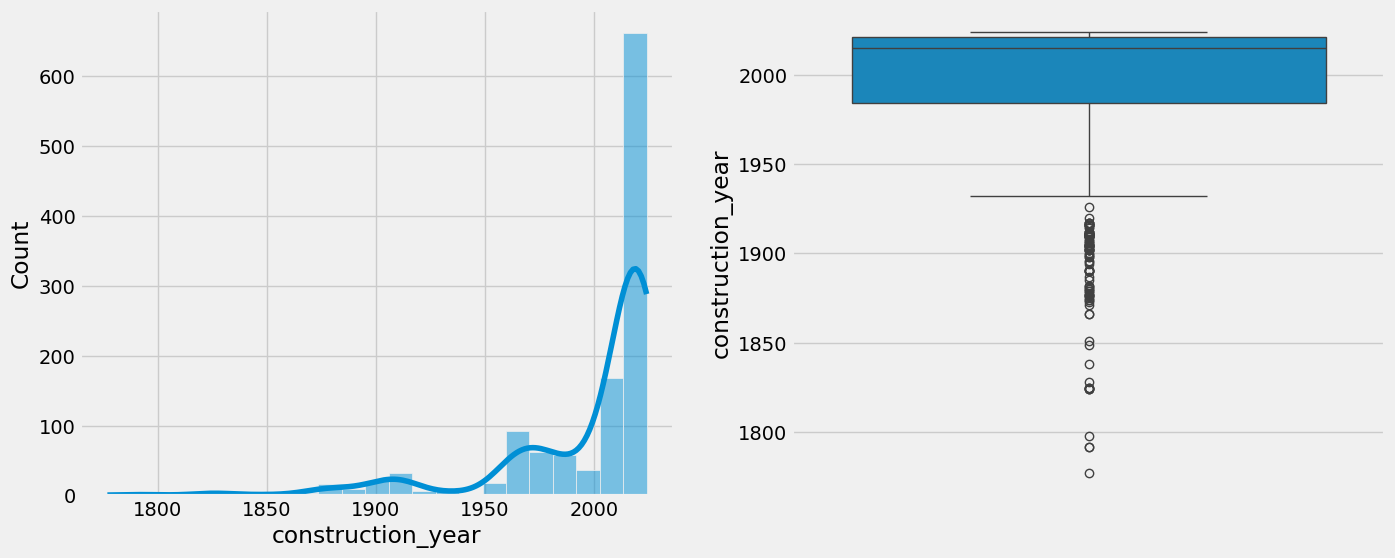

In [221]:
hist_box_plot(df, 'construction_year', True)

Number of observations: 1352
Number of None: 142
None ratio: 0.10502958579881656


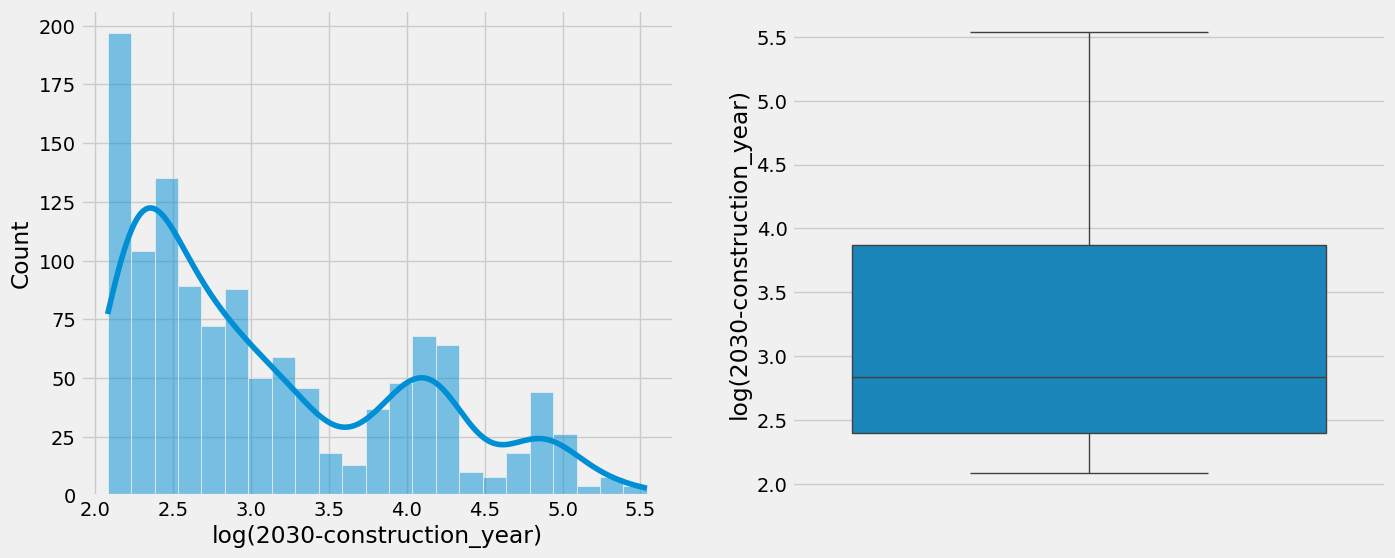

In [226]:
hist_box_plot(df[['construction_year']].map(lambda x: np.log1p(2031-x)), 'construction_year', True, 'log(2030-construction_year)')

### Floor

Number of observations: 1352
Number of None: 1
None ratio: 0.0007396449704142012


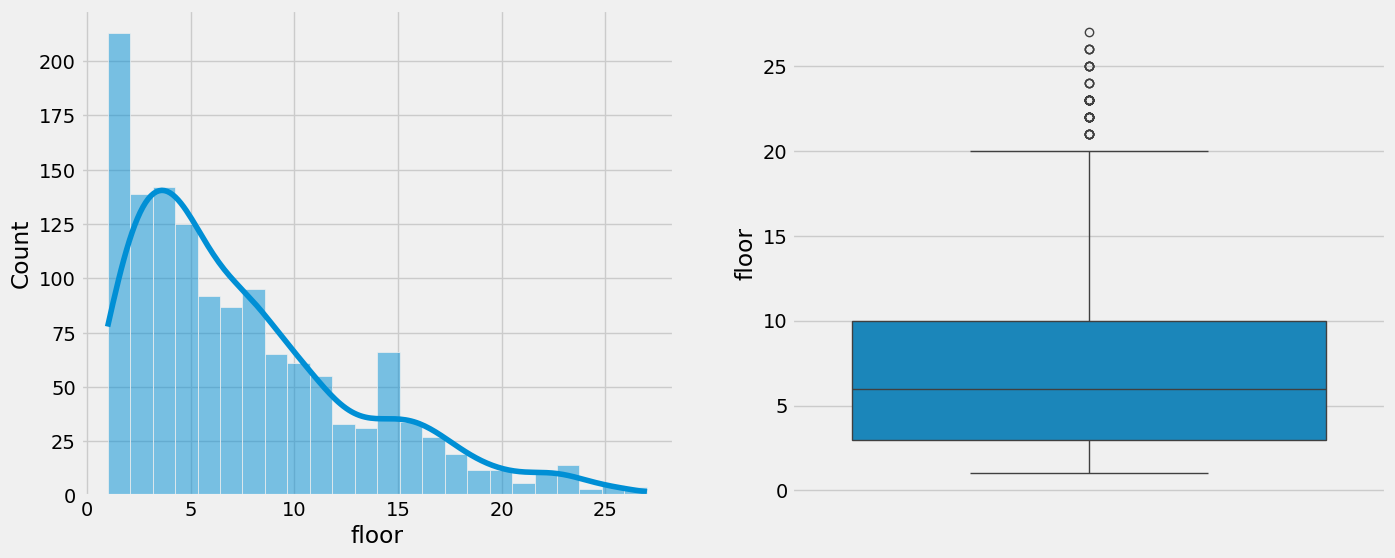

In [227]:
hist_box_plot(df, 'floor', True)

Number of observations: 1352
Number of None: 1
None ratio: 0.0007396449704142012


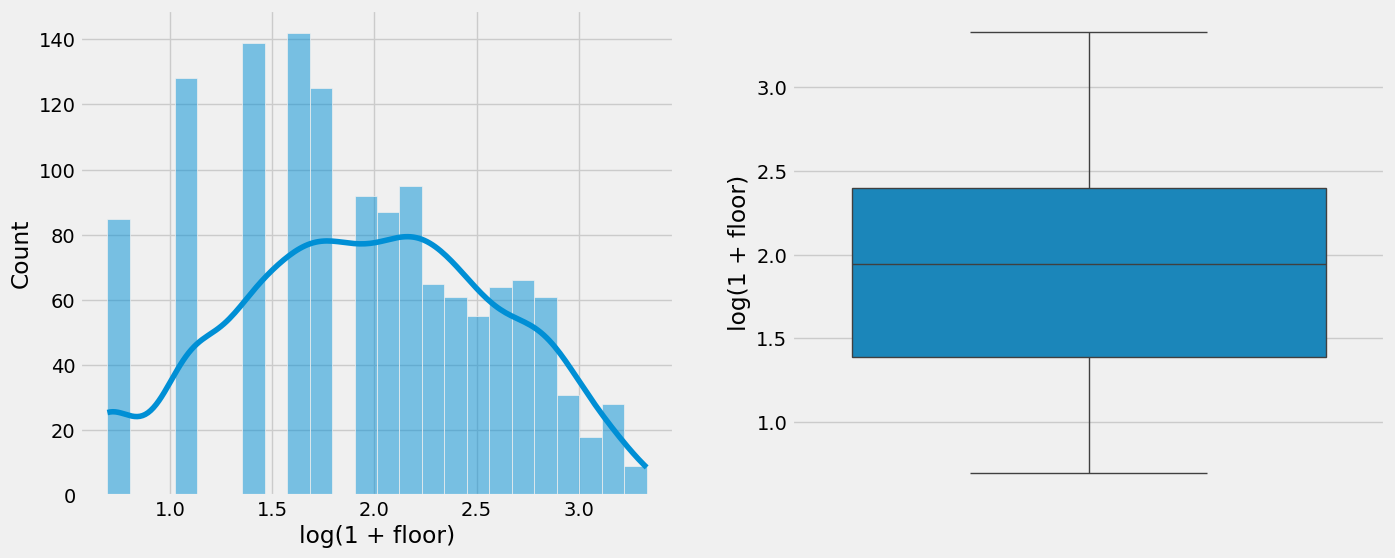

In [228]:
hist_box_plot(df[['floor']].map(np.log1p), 'floor', True, 'log(1 + floor)')

### Total floors

Number of observations: 1352
Number of None: 6
None ratio: 0.004437869822485207


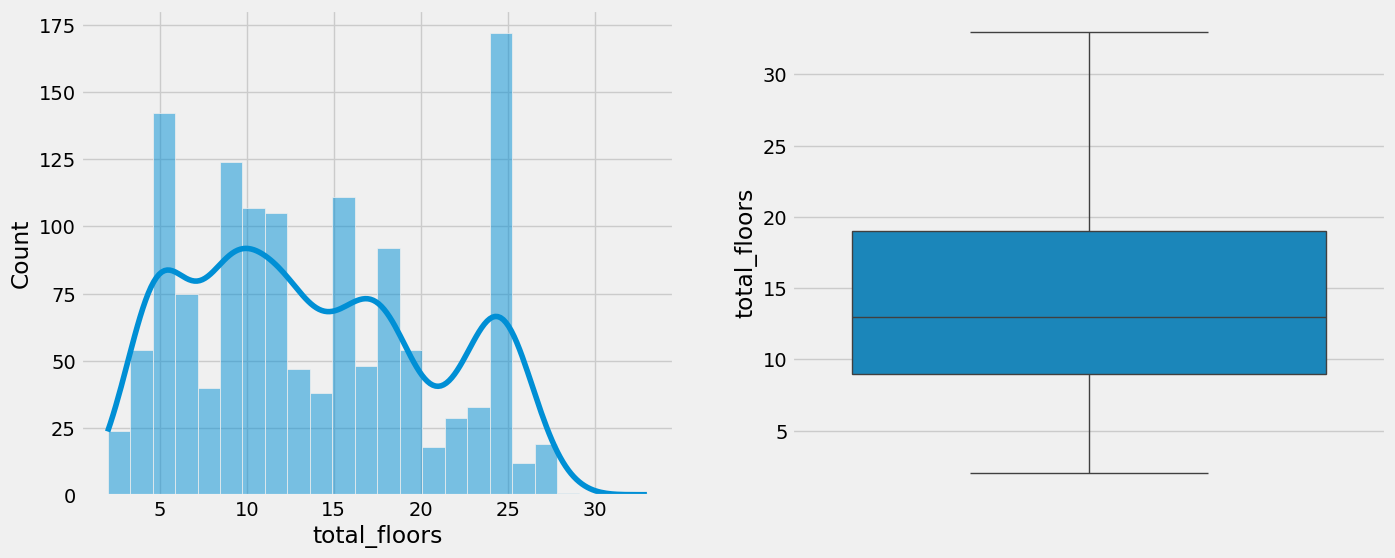

In [229]:
hist_box_plot(df, 'total_floors', True)

### Area

Number of observations: 1352
Number of None: 0
None ratio: 0.0


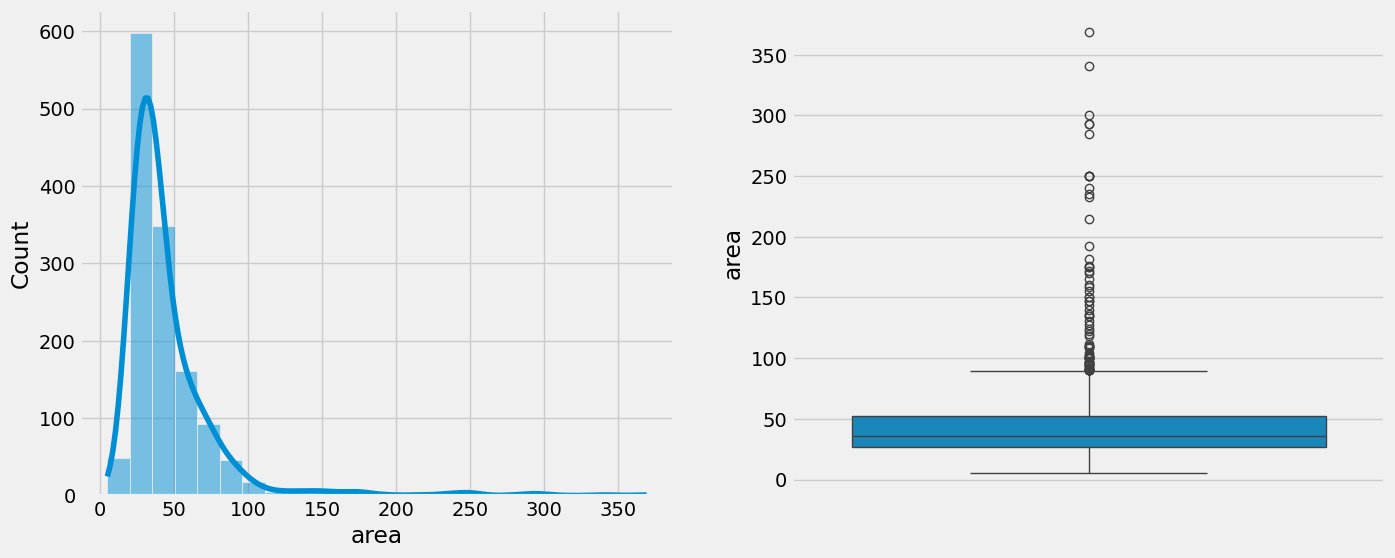

In [230]:
hist_box_plot(df, 'area', True)

Number of observations: 1352
Number of None: 0
None ratio: 0.0


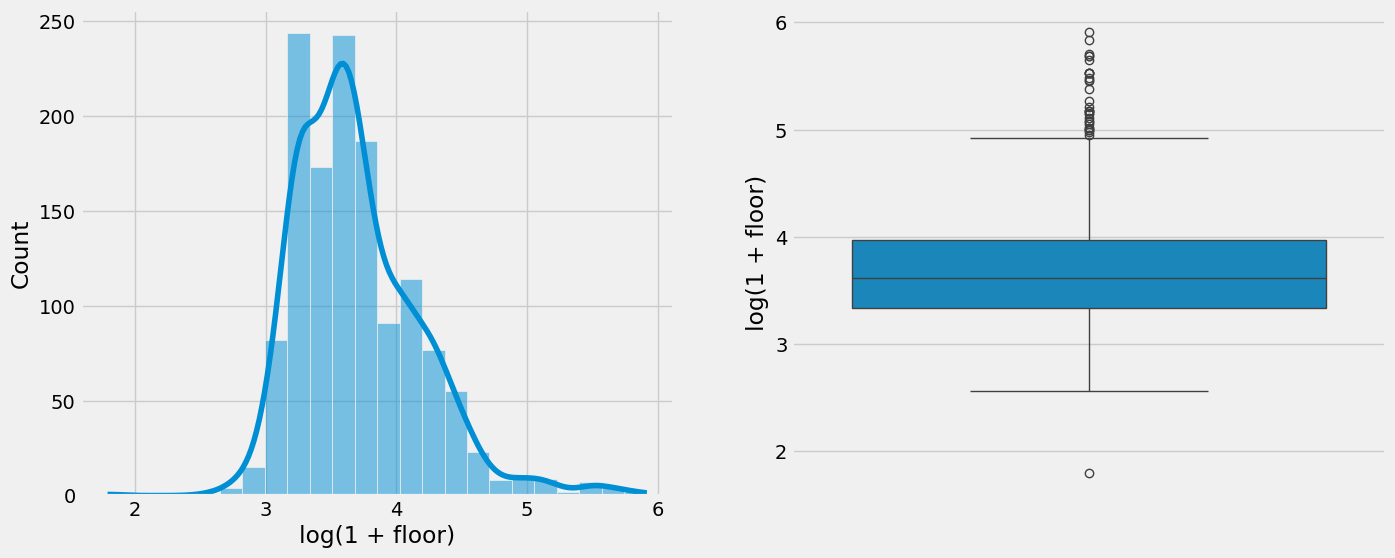

In [231]:
hist_box_plot(df[['area']].map(np.log1p), 'area', True, 'log(1 + floor)')

Number of observations: 1320
Number of None: 0
None ratio: 0.0


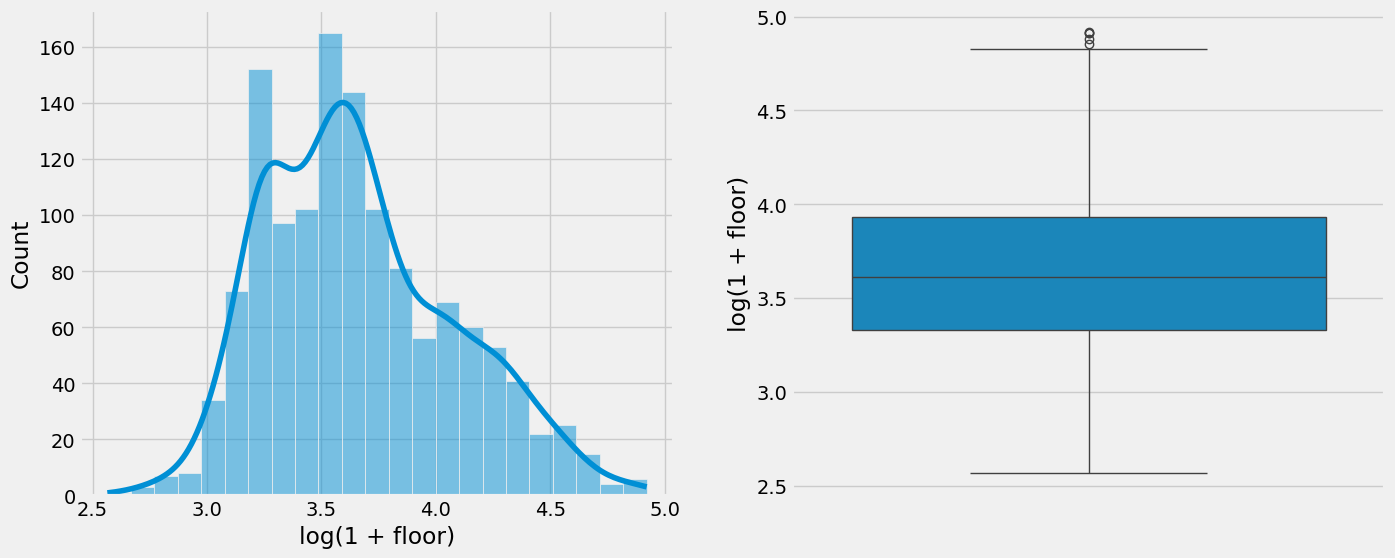

In [232]:
hist_box_plot(iqr_filter(df[['area']].map(np.log1p), 'area'), 'area', True, 'log(1 + floor)')

### pledge

Number of observations: 1352
Number of None: 541
None ratio: 0.40014792899408286


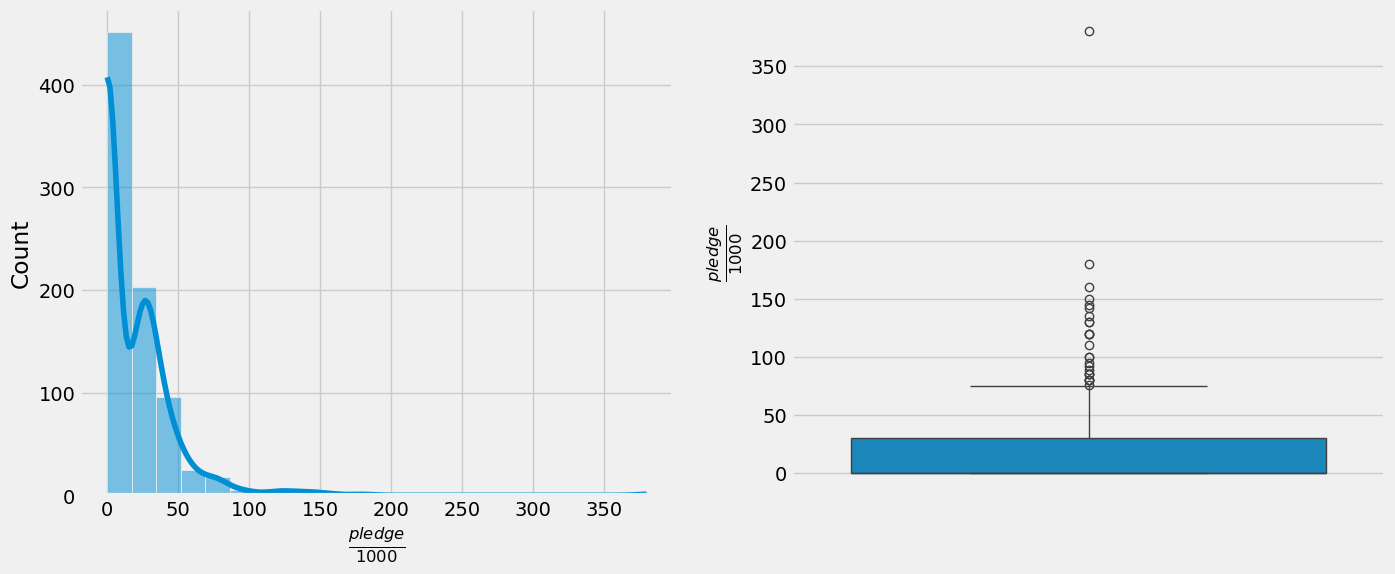

In [240]:
hist_box_plot(df[['pledge']]/1000, 'pledge', True, '$\\frac{pledge}{1000}$')

Let's consider only non-zero pledge

Number of observations: 381
Number of None: 0
None ratio: 0.0


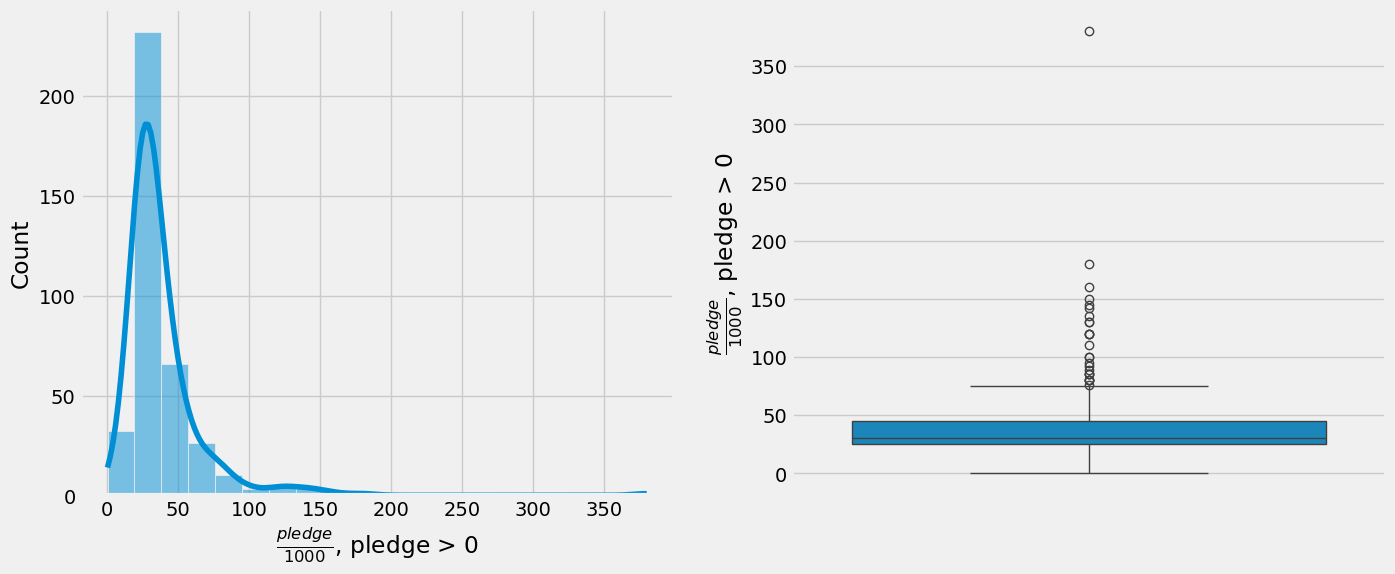

In [260]:
hist_box_plot(df[df['pledge'] > 0][['pledge']]/1000, 'pledge', True, '$\\frac{pledge}{1000}$, pledge > 0')

Number of observations: 381
Number of None: 0
None ratio: 0.0


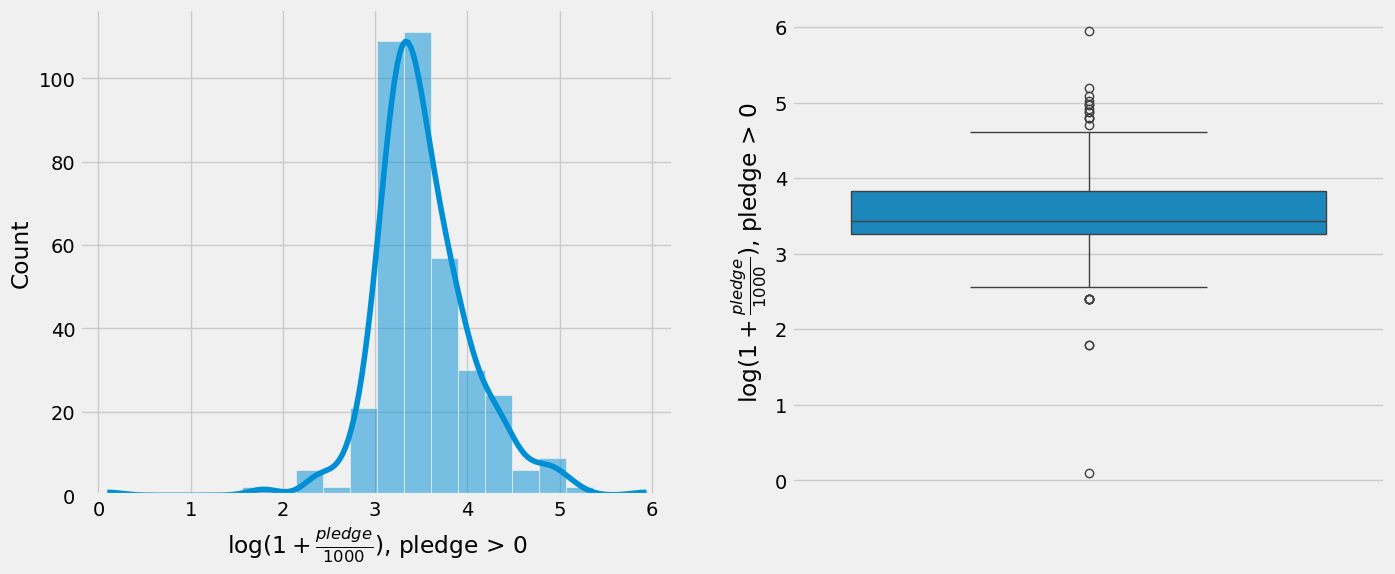

In [252]:
hist_box_plot(df[df['pledge'] > 0][['pledge']].map(lambda x: np.log1p(x/1000)), 'pledge', True, '$\log(1+\\frac{pledge}{1000})$, pledge > 0')

Number of observations: 359
Number of None: 0
None ratio: 0.0


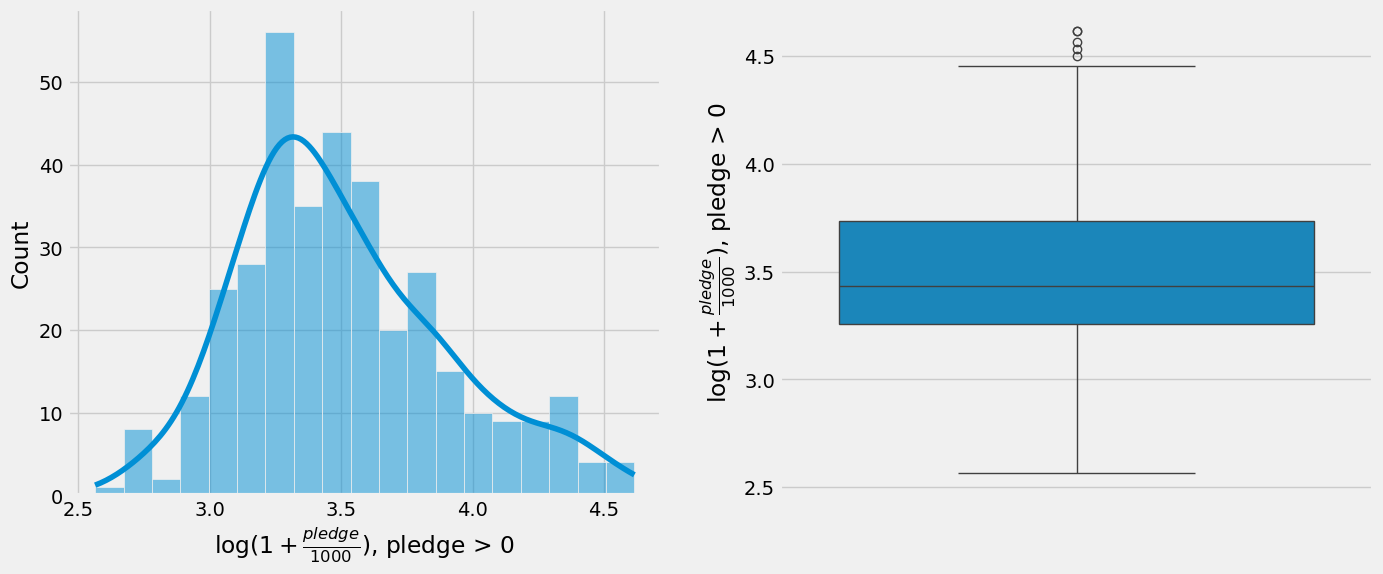

In [254]:
hist_box_plot(iqr_filter(df[df['pledge'] > 0][['pledge']].map(lambda x: np.log1p(x/1000)), 'pledge'), 
              'pledge', True, '$\log(1+\\frac{pledge}{1000})$, pledge > 0')

### commission_fee

Number of observations: 1352
Number of None: 0
None ratio: 0.0


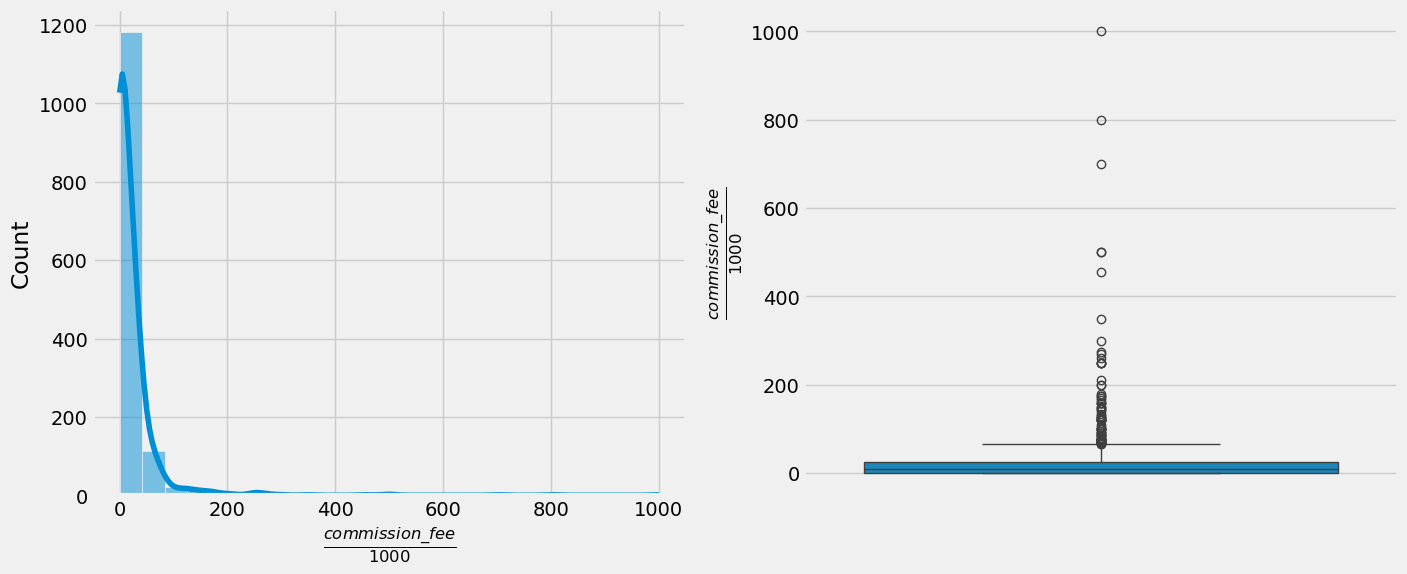

In [257]:
hist_box_plot(df[['commission_fee']]/1000, 'commission_fee', True, '$\\frac{commission\_fee}{1000}$')

Let's consider only non-zero values

Number of observations: 697
Number of None: 0
None ratio: 0.0


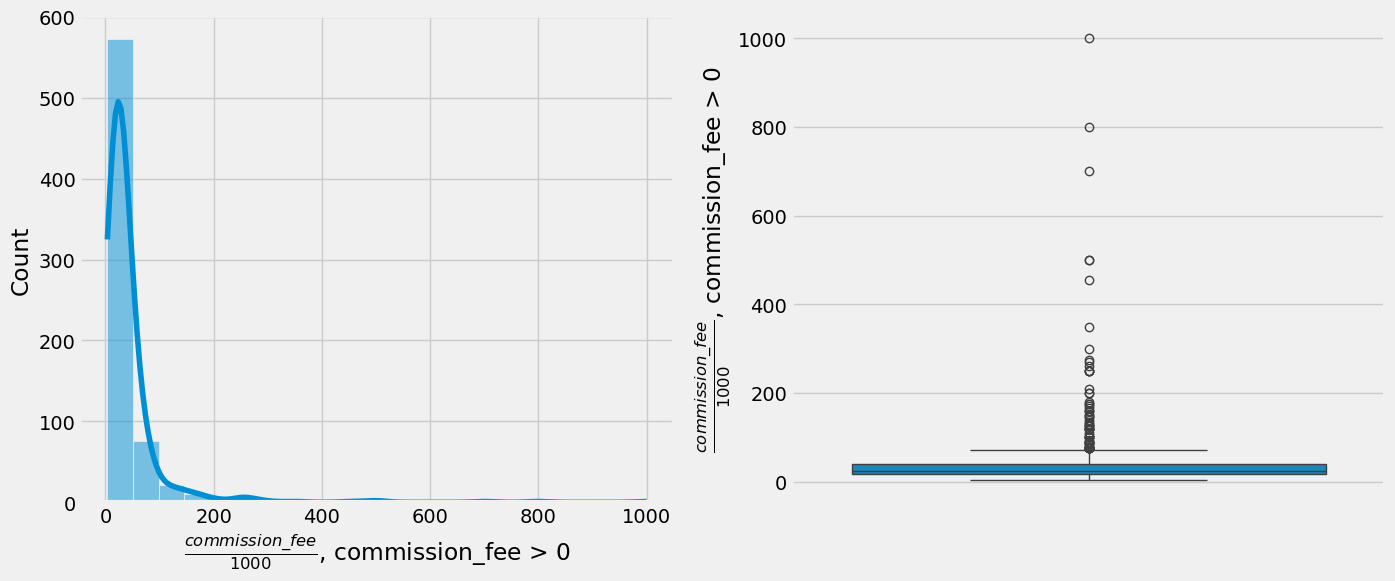

In [262]:
hist_box_plot(df[df['commission_fee'] > 0][['commission_fee']]/1000, 
              'commission_fee', True, '$\\frac{commission\_fee}{1000}$, commission_fee > 0')

Number of observations: 697
Number of None: 0
None ratio: 0.0


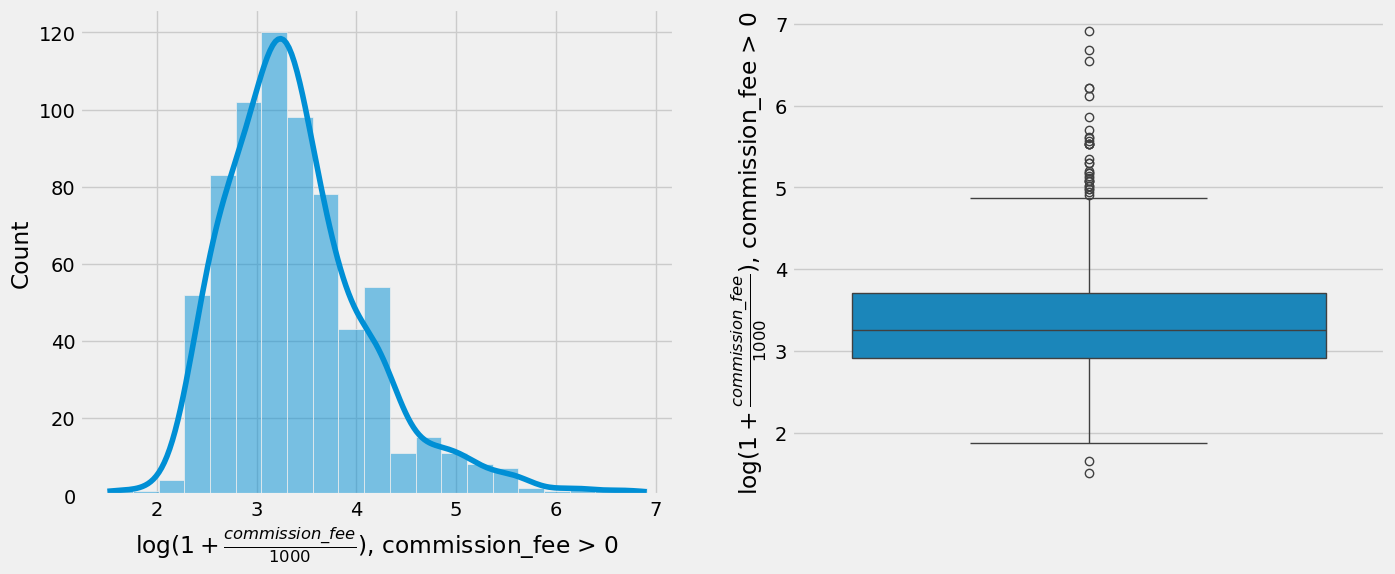

In [263]:
hist_box_plot(df[df['commission_fee'] > 0][['commission_fee']].map(lambda x: np.log1p(x/1000)), 
              'commission_fee', True, '$\log(1+\\frac{commission\_fee}{1000})$, commission_fee > 0')

Number of observations: 663
Number of None: 0
None ratio: 0.0


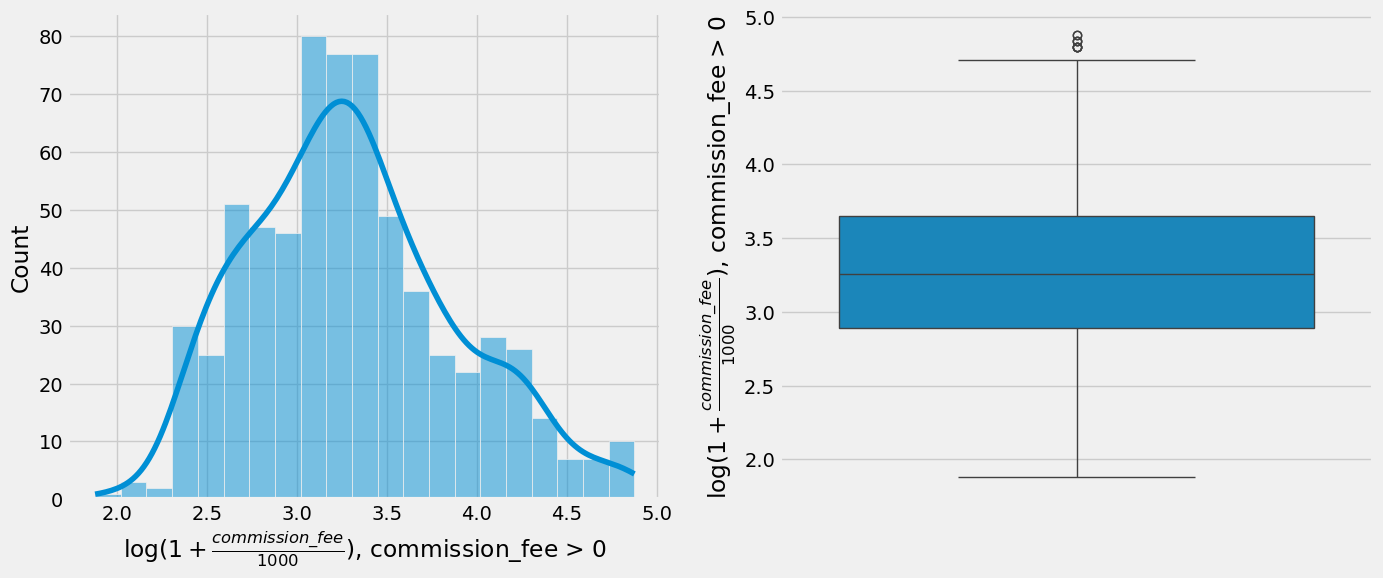

In [264]:
hist_box_plot(iqr_filter(df[df['commission_fee'] > 0][['commission_fee']].map(lambda x: np.log1p(x/1000)), 'commission_fee'), 
              'commission_fee', True, '$\log(1+\\frac{commission\_fee}{1000})$, commission_fee > 0')

### price

Number of observations: 1352
Number of None: 0
None ratio: 0.0


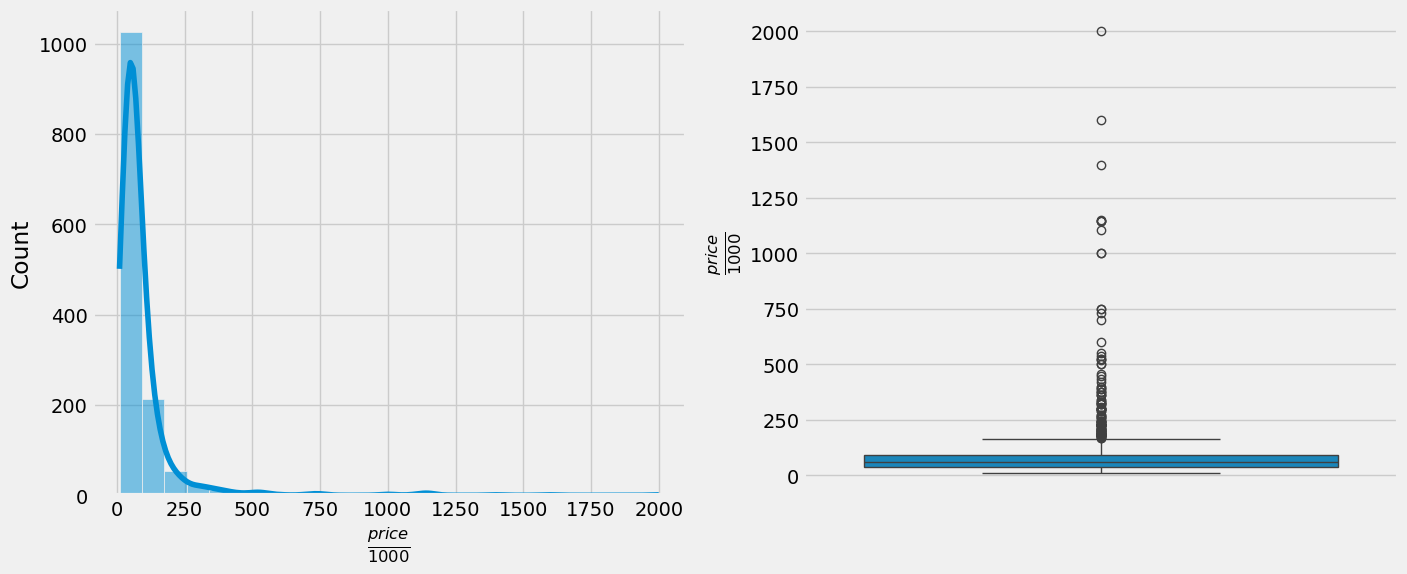

In [273]:
hist_box_plot(df[['price']]/1000, 'price', True, '$\\frac{price}{1000}$')

Number of observations: 1352
Number of None: 0
None ratio: 0.0


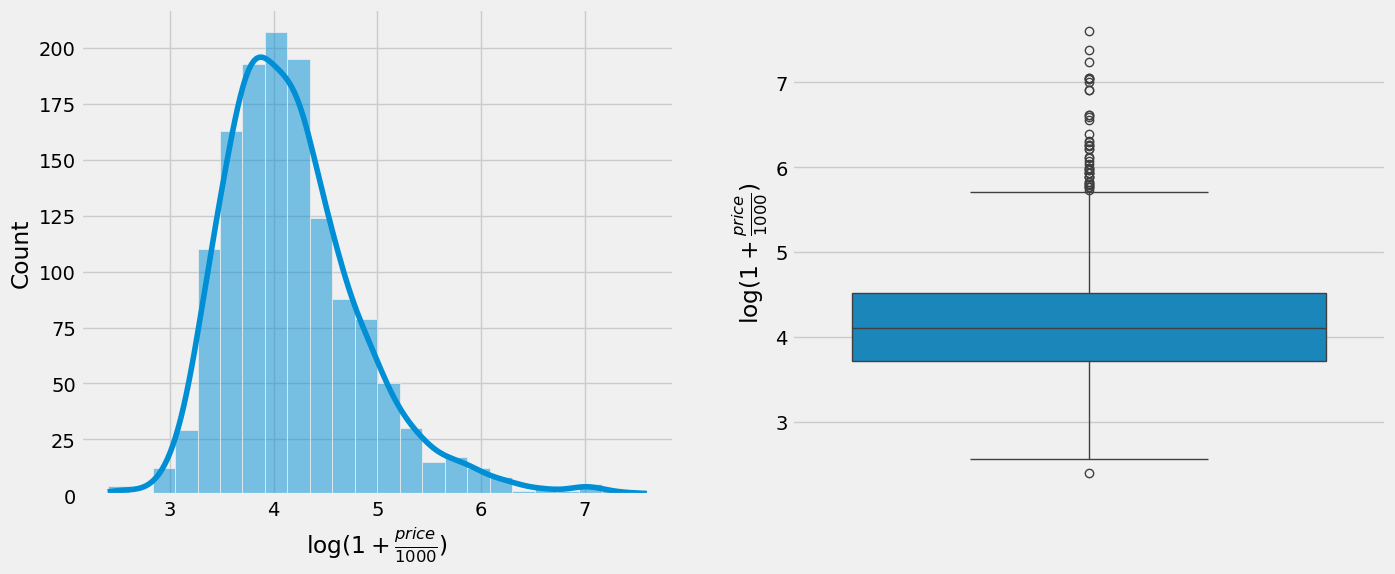

In [274]:
hist_box_plot(df[['price']].map(lambda x: np.log1p(x/1000)), 'price', True, '$\log(1+\\frac{price}{1000})$')

Number of observations: 1306
Number of None: 0
None ratio: 0.0


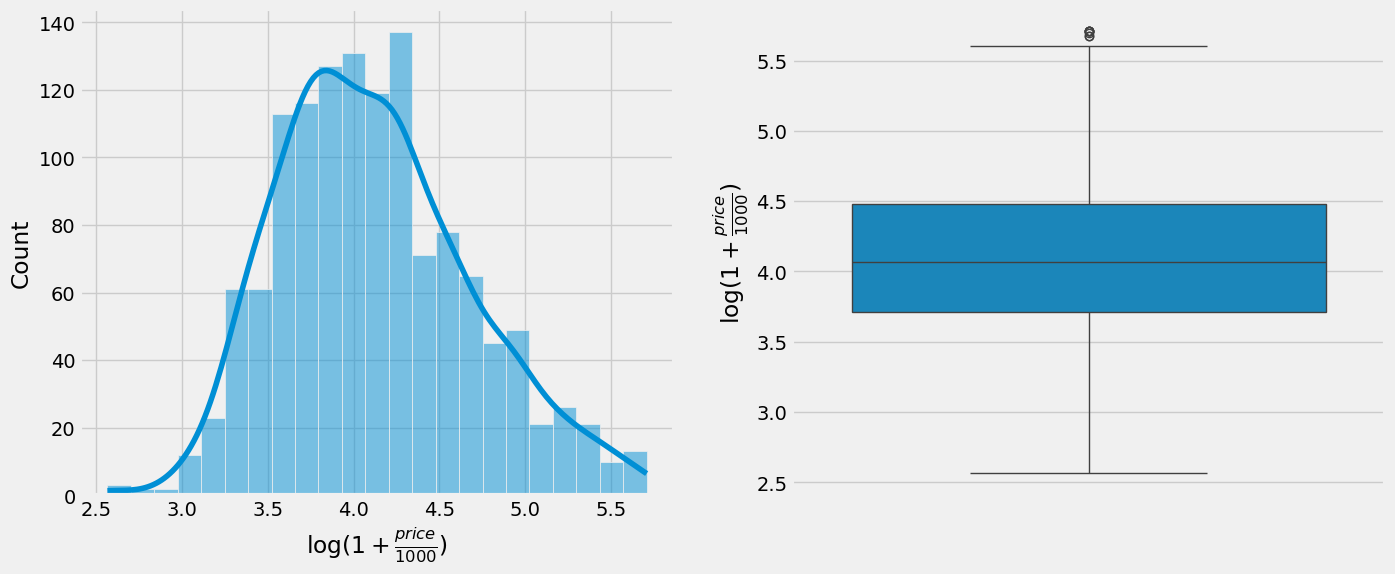

In [275]:
hist_box_plot(iqr_filter(df[['price']].map(lambda x: np.log1p(x/1000)), 'price'), 'price', True, '$\log(1+\\frac{price}{1000})$')

### latitude & longitude

In [286]:
addresses = read_table_from_database('addresses', True).set_index('address_id')

[2024-07-16 15:51:06,997: 446: logger: INFO: utils: Table addresses has been read from the source database]


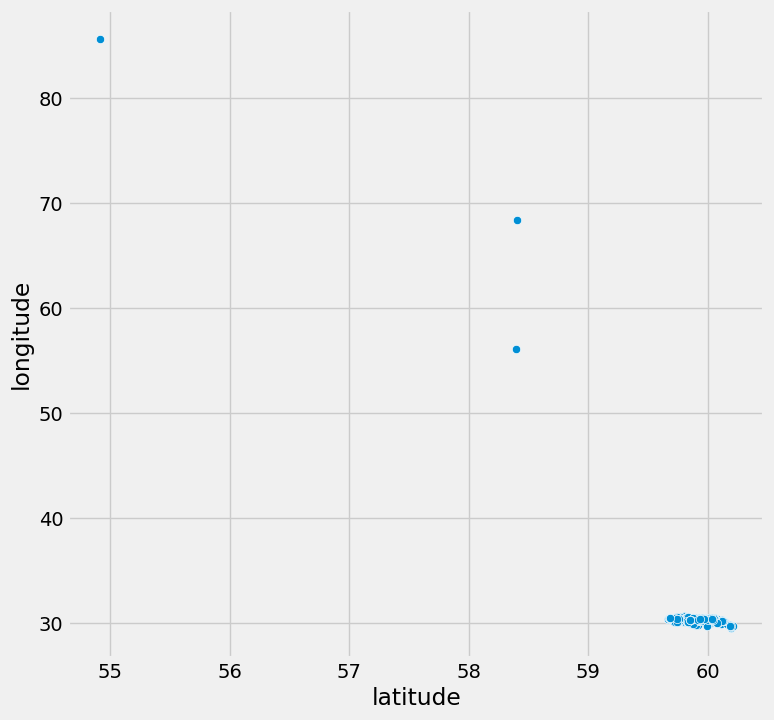

In [306]:
plt.subplots(1, figsize=(8, 8))
sns.scatterplot(x=addresses['latitude'], y=addresses['longitude'])
plt.show()

clearly there are few outliers, which are far from the city

let's apply iqr_filter for both coordinates

Initial number of observations: 937
Number of observations after IQR filtering along feature "latitude": 932


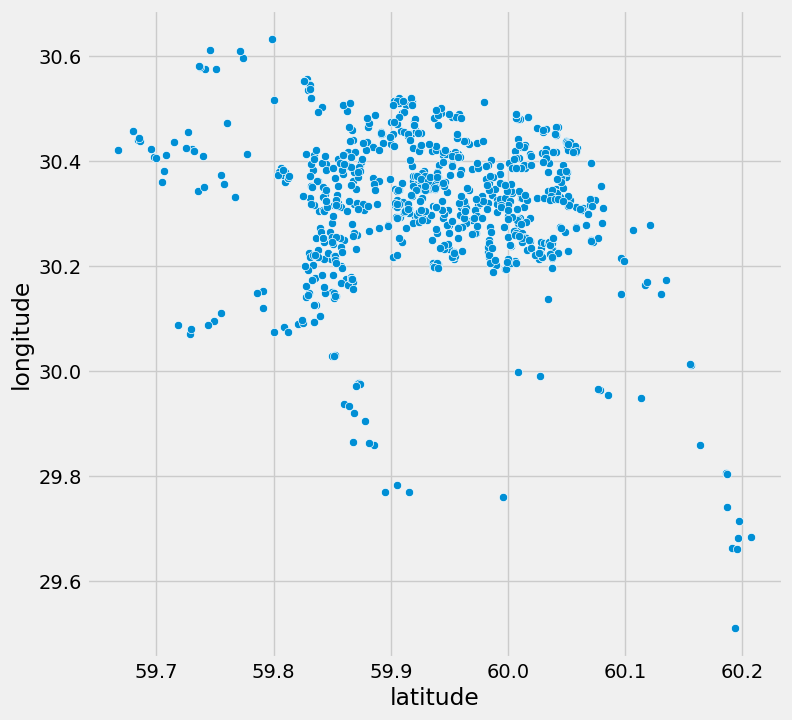

In [305]:
addresses2 = iqr_filter(addresses, 'latitude')
plt.subplots(1, figsize=(8, 8))
sns.scatterplot(x=addresses2['latitude'], y=addresses2['longitude'])
plt.show()

Initial number of observations: 937
Number of observations after IQR filtering along feature "longitude": 899


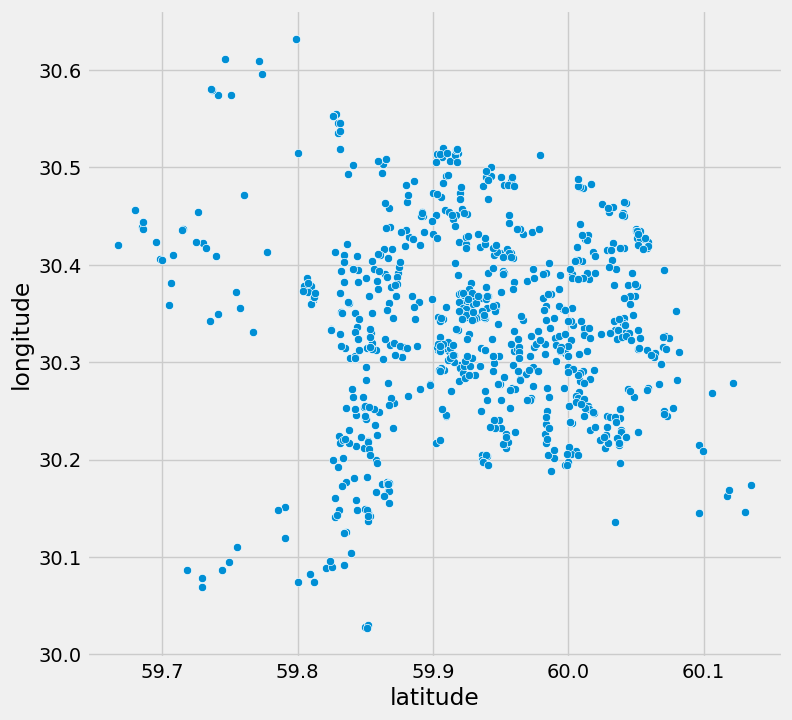

In [307]:
addresses2 = iqr_filter(addresses, 'longitude')
plt.subplots(1, figsize=(8, 8))
sns.scatterplot(x=addresses2['latitude'], y=addresses2['longitude'])
plt.show()

Initial number of observations: 937
Number of observations after IQR filtering along feature "latitude": 932
Initial number of observations: 932
Number of observations after IQR filtering along feature "longitude": 898


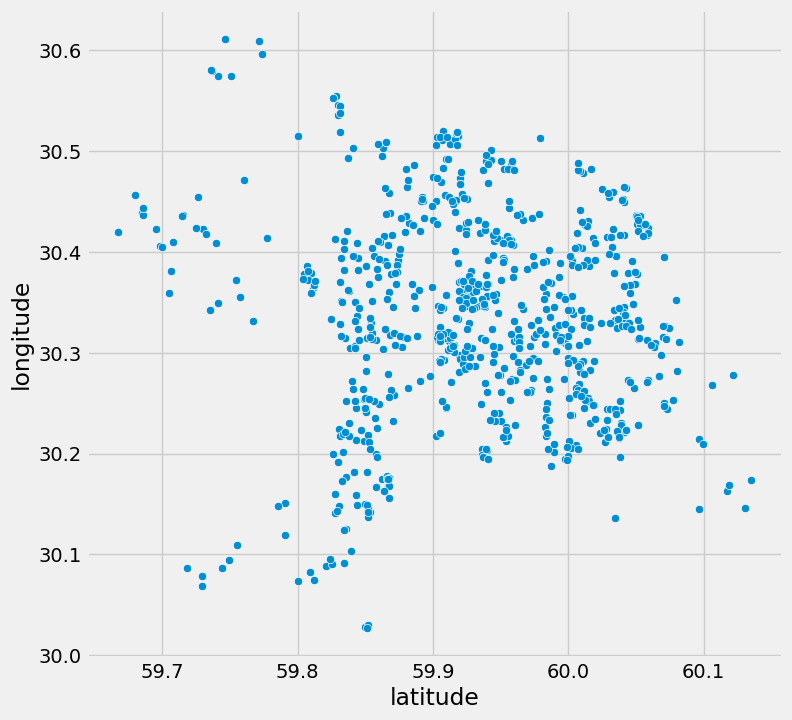

In [308]:
addresses2 = iqr_filter(iqr_filter(addresses, 'latitude'), 'longitude')
plt.subplots(1, figsize=(8, 8))
sns.scatterplot(x=addresses2['latitude'], y=addresses2['longitude'])
plt.show()